<a href="https://colab.research.google.com/github/BrunoArsioli/2BIGB-GammaRay-Blazar-Catalog/blob/master/Copy_of_DataWrangling_USS_Quasars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Allow google.colab to access files in your drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # to show progress bar in for loops


# Lets use Astropy for the cross-match based in R.A. and Dec positions
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude # Angles
import astropy.coordinates 
import astropy.units as u

#Install Astroquery
!pip install astroquery
import astroquery
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy.table import Table, join, vstack
from astropy import units as u 

# set max columns
pd.options.display.max_columns = 1000

# Create a SkyCoord object for each set of coordinates
#import astropy.coordinates as coord

datapath_wrang   = "/content/drive/MyDrive/data/Module_DataWrang_2023_data"

In [ ]:
df = []

## load database and convert to Python dataframes

In [ ]:
#Read you data and store an pandas df
#Read your fits data with 'Table.read' which is a function from Astropy, and convert to pandas dataframe
dfimo = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/imogen_python.fits', format='fits' )
dfmig = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/mightee_python.fits', format='fits')

dfimo = dfimo.to_pandas() #"s" to mark the small catalog 
dfmig = dfmig.to_pandas() #"b" to mark the big catalog

#create new columns in each db, to track the db name.
dfimo['DB_NAME'] = 'imogen'
dfmig['DB_NAME'] = 'mightee'

In [ ]:
# if you want to use might as the base cat 
# save it as a .copy() from might while removing unecessary columns
df = dfmig.drop(columns={'IM_MAJ', 'E_IM_MAJ', 'IM_MIN', 'E_IM_MIN', 'IM_PA', 'E_IM_PA', 'THETA_MAJ', 
                        'E_THETA_MAJ', 'THETA_MIN', 'E_THETA_MIN', 'GAUS_ID', 'SRC_ID', 'ISL_ID'}).copy()

# create a column to store redshift values and origin; for now, fill it with np.nan values
df['z'] = np.nan
df['z_origin'] = np.nan

# reset index
df.reset_index(drop=True, inplace=True)

# check on the remaining columns
df.head(2)

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,RESOLVED,ISL_RMS,Fluxfinal,SNR,POINT,DB_NAME,z,z_origin
0,b'J100320.73+020931.7',150.836411,0.00029,2.15882,0.00030,0.000104,0.000029,0.000056,0.000011,1.304066e+09,0.000099,0.000028,0.000053,0.00001,0,0.00001,0.000104,5.550000,1.508368,mightee,NaN,NaN
1,b'J100320.26+021312.7',150.834427,0.00003,2.22022,0.00008,0.000370,0.000024,0.000248,0.000010,1.304925e+09,0.000353,0.000022,0.000236,0.00001,1,0.00001,0.000370,25.567009,1.059901,mightee,NaN,NaN


In [ ]:
##############################################
# Want to start with a different base-table? #
##############################################

# Read your .fits local df
#df = Table.read('/content/drive/MyDrive/data/xxxxxxNewSeletion.fits')

# or .csv file
#df = pd.read_csv('/content/drive/MyDrive/data/xxxxxxNewSelection.csv')

## add Point Source Criteria 

Here we calculate C according to 

S_int / S_peak = 1 + ( C / snr^1.4 )

C = ( ( S_int / S_peak ) - 1 ) * (snr^1.4) 

* Note: all sources in df have S_Int and S_peak 

In [ ]:
print(f"number of Might sources with null S_Int: {df['S_INT'].isnull().sum()} ")
print(f"number of Might sources with null S_Peak: {df['S_PEAK'].isnull().sum()} ")

number of Might sources with null S_Int: 0 
number of Might sources with null S_Peak: 0 


In [ ]:
# calculate POINT values
df['POINT'] = 1+ (5.6 / ( df['SNR']**(1.4) ))
df['S_I/P'] = (df['S_INT']/df['S_PEAK'])

In [ ]:
#mask1 = df['POINT'] > df['S_I/P']

dfclean1 = df[ df['POINT'] > df['S_I/P'] ].copy() 

#mask2 = (1/dfclean1['POINT']) < dfclean1['S_I/P']

dfclean2 =  dfclean1[ (1/dfclean1['POINT']) < dfclean1['S_I/P'] ].copy() 

In [ ]:
# creat mask to select the brightest sources 
mask2 = df['S_PEAK']>0.01

# create a subsamole with the brigh sources
df2 = df[ mask2 ]

#df2.head()
df2

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,RESOLVED,ISL_RMS,Fluxfinal,SNR,POINT,DB_NAME,z,z_origin,S_I/P
215,b'J100252.87+015549.4',150.720337,0.0,1.93041,0.0,0.017555,0.000017,0.017333,0.000010,1.317629e+09,0.016826,0.000016,0.016612,0.000009,1,0.000010,0.017555,1805.489380,1.000154,mightee,NaN,NaN,1.012854
307,b'J100242.56+015938.5',150.677368,0.0,1.99404,0.0,0.022369,0.000014,0.024356,0.000009,1.330282e+09,0.021583,0.000014,0.023501,0.000008,1,0.000009,0.024356,2799.586426,1.000084,mightee,NaN,NaN,0.918403
795,b'J100217.96+015836.1',150.574860,0.0,1.97671,0.0,0.026073,0.000012,0.025939,0.000007,1.343968e+09,0.025338,0.000011,0.025207,0.000007,1,0.000007,0.026073,3871.432861,1.000053,mightee,NaN,NaN,1.005197
1009,b'J100208.73+024103.2',150.536407,0.0,2.68423,0.0,0.011054,0.000015,0.010836,0.000009,1.323164e+09,0.010626,0.000014,0.010416,0.000008,1,0.000009,0.011054,1274.764771,1.000252,mightee,NaN,NaN,1.020184
4184,b'J100043.60+014602.4',150.181686,0.0,1.76735,0.0,0.024587,0.000016,0.016735,0.000007,1.352313e+09,0.023997,0.000016,0.016334,0.000007,1,0.000007,0.024587,2497.835693,1.000098,mightee,NaN,NaN,1.469134
4185,b'J100042.86+014612.9',150.178604,0.0,1.77027,0.0,0.034663,0.000017,0.022838,0.000007,1.352688e+09,0.033839,0.000016,0.022295,0.000007,1,0.000007,0.034663,3408.686523,1.000063,mightee,NaN,NaN,1.517777
4186,b'J100043.14+014607.4',150.179779,0.0,1.76873,0.0,0.018060,0.000013,0.015998,0.000007,1.352518e+09,0.017629,0.000013,0.015616,0.000007,1,0.000007,0.018060,2387.701416,1.000104,mightee,NaN,NaN,1.128907
4840,b'J100029.35+024044.7',150.122284,0.0,2.67909,0.0,0.019868,0.000017,0.013555,0.000008,1.348792e+09,0.019356,0.000017,0.013206,0.000007,1,0.000007,0.019868,1909.084595,1.000143,mightee,NaN,NaN,1.465764
8114,b'J095908.30+024309.5',149.784622,0.0,2.71932,0.0,0.025080,0.000016,0.024726,0.000009,1.327427e+09,0.024162,0.000015,0.023822,0.000009,1,0.000009,0.025080,2778.213623,1.000085,mightee,NaN,NaN,1.014297
8116,b'J095909.14+024301.3',149.788086,0.0,2.71705,0.0,0.021067,0.000016,0.020557,0.000009,1.328111e+09,0.020304,0.000015,0.019812,0.000009,1,0.000009,0.021067,2309.719238,1.000109,mightee,NaN,NaN,1.024834


<function matplotlib.pyplot.show(close=None, block=None)>

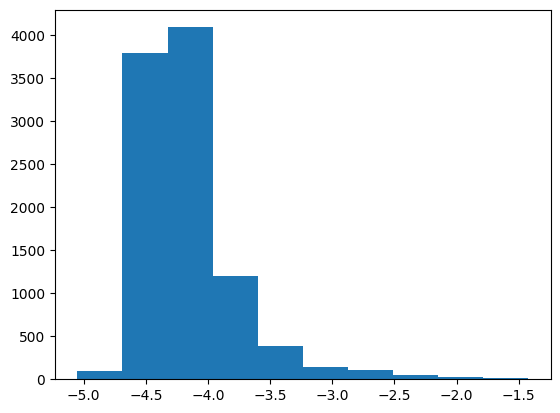

In [ ]:
plt.hist(np.log10(df['S_PEAK']))
plt.show

In [ ]:
lista = (1/dfclean1['POINT']) < dfclean1['S_I/P']

lista

2       True
3       True
5       True
6       True
7       True
        ... 
9891    True
9892    True
9893    True
9894    True
9895    True
Length: 7423, dtype: bool

In [ ]:
# Number of sources left:
dfclean2.shape[0]

7124

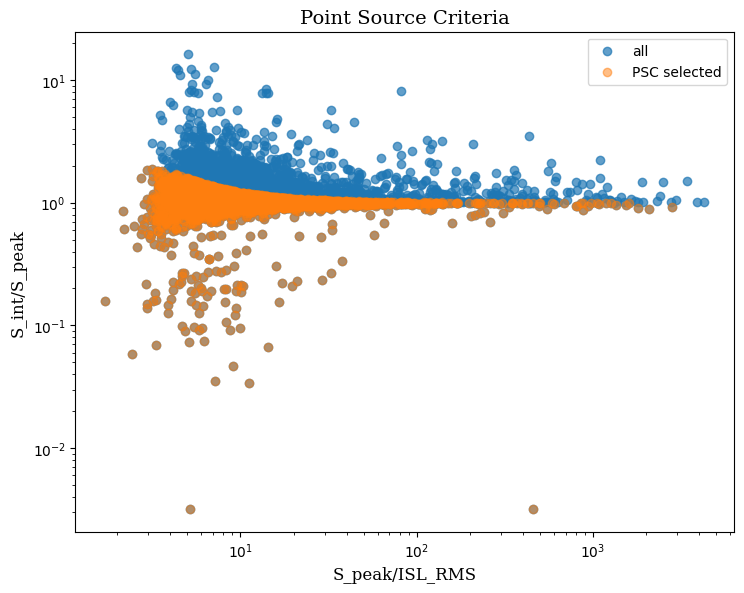

In [ ]:
# create a test mask
mask_test = dfclean1.index

# create a mask
mask = dfclean2.index

# and you can control the size of the figure, and font size
plt.figure(figsize=(8.5,6.5))

# define x and y values
#xvalue =  df['S_PEAK']/df['VLA_rms']
xvalue =  df['S_PEAK']/df['ISL_RMS']
yvalue =  df['S_INT']/df['S_PEAK']

# define C_lim
#C_lim = 5.6

plt.scatter( x = xvalue, y = yvalue, label="all", alpha=0.7 )

#plt.scatter( x = xvalue[mask], y = yvalue[mask], label=f"PSC selected", alpha=0.5 )
plt.scatter( x = xvalue[mask_test], y = yvalue[mask_test], label=f"PSC selected", alpha=0.5 )

plt.legend(loc="upper right")

# Add title and axis names
plt.title('Point Source Criteria', font='serif', size=14)
plt.xlabel('S_peak/ISL_RMS'  , font='serif', size=12)
plt.ylabel('S_int/S_peak', font='serif', size=12)

# set log scale
plt.xscale('log')
plt.yscale('log')

# set plot limits
#plt.ylim(0.2,12)

plt.show()

In [ ]:
############################
# Save and !! UPDATE !! df #
############################

# keep a copy of initial df
dfkeep = df.copy()

# update df to dfclean2
df = dfclean2.copy()

# reset index
df.reset_index(drop=True, inplace=True)

# erras dfclean1 and dfclean2
dfclean1 = []
dfclean2 = []

# PSC: Point Source Criteria
df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_V2.csv")

## add z values

In [ ]:
# specify the path to the folder where your z tables are stored
path_z = '/content/drive/MyDrive/data/Module_DataWrang_2023_data' 

# redshift dataframe
dfz1 = pd.read_csv(f"{path_z}/zcosmos.csv")
dfz2 = pd.read_csv(f"{path_z}/zdeimos.csv")
dfz3 = pd.read_csv(f"{path_z}/zspec_zphot.csv") #might

# rename coordinate columns from all tables to: ra & dec
dfz1.rename(columns={'ALPHA_J2000':'ra', 'DELTA_J2000':'dec'}, inplace=True)
dfz2.rename(columns={'Ra'         :'ra', 'Dec'        :'dec'}, inplace=True)
dfz3.rename(columns={'RA_1'       :'ra', 'DEC_1'      :'dec'}, inplace=True)

# reset index
dfz1.reset_index(drop=True, inplace=True)
dfz2.reset_index(drop=True, inplace=True)
dfz3.reset_index(drop=True, inplace=True)

# dislay tables
display(dfz1.head(2))
display(dfz2.head(2))
display(dfz3.head(2))

,ra,dec,lp_zBEST
0,150.743143,1.604493,0.0
1,150.391586,1.604716,0.0


,ID,ra,dec,imag,kmag,zspec,Qf,Q
0,C1785365,149.358553,2.750301,20.11,20.19,0.5655,2,1.5
1,C1343700,149.366394,2.376694,22.89,21.73,0.7080,3,2.0


,ra,dec,Z_Phot,specz_redshift
0,150.077545,1.594500,0.5020,NaN
1,149.947491,1.602141,0.4605,NaN


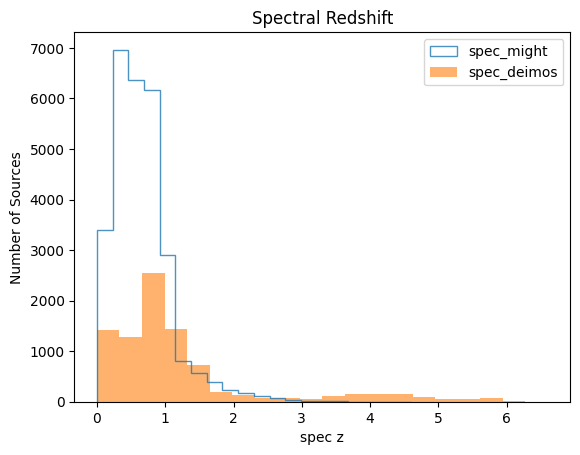

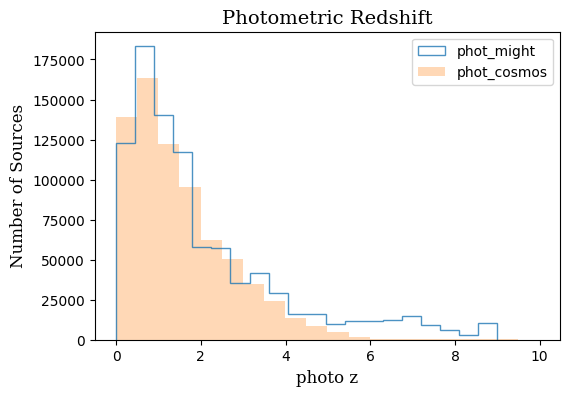

In [ ]:
##################################
# check on histogram of z values #
##################################

# in plt.hist, use flag " histtype='step' " to plot just the bin-lines (i.e. avoid bins color-filled bins)
plt.hist(dfz3['specz_redshift'], bins=20, label="spec_might", alpha=0.8, histtype='step')
plt.hist(dfz2['zspec'], bins=20, label="spec_deimos", alpha=0.6)
plt.legend(loc="upper right")
# Add title and axis names
plt.title('Spectral Redshift')
plt.xlabel('spec z')
plt.ylabel('Number of Sources')
plt.show()


# note, here we plot only dfz3['Z_Phot'] when dfz3['Z_Phot'] >= 0.0. keep this kind python sintax in mind
# and you can control the size of the figure, and font size
plt.figure(figsize=(6,4))
plt.hist( dfz3['Z_Phot'][dfz3['Z_Phot'] >= 0.0], bins=20, label="phot_might", alpha=0.8, histtype='step')
plt.hist(dfz1['lp_zBEST'], bins=20, label="phot_cosmos", alpha=0.3)
plt.legend(loc="upper right")
# Add title and axis names
plt.title('Photometric Redshift', font='serif', size=14)
plt.xlabel('photo z', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)
plt.show()


In [ ]:
###################################################
# loop to add the redshifts according to priority #
################################################### 

# define object with coordinates from Might cat
c1 = SkyCoord( ra = np.array(df['RA'])*u.deg, dec = np.array(df['DEC'])*u.deg, frame='icrs')

# create a list with the dfz names that will be used, following priority and z_column ordering
dfz_list = [dfz1, dfz3, dfz2, dfz3]

# create a list with the names of the redshift datasets 
z_origin = ['cosm_ph', 'might_ph', 'deim_spec', 'might_spec']

# create a list of the column names with info about redshift 
z_column = ['lp_zBEST', 'Z_Phot', 'zspec', 'specz_redshift']


# create a list with the dfz names that will be used, following priority and z_column ordering
#dfz_list = [dfz1, dfz2, dfz3, dfz3]

# create a list with the names of the redshift datasets 
#z_origin = ['cosm_ph', 'deim_spec', 'might_spec', 'might_ph']

# create a list of the column names with info about redshift 
#z_column = ['lp_zBEST', 'zspec', 'specz_redshift','Z_Phot']





#########################################
# loop over the z catalogs in dfz_names #
#########################################

# enumerate() is used: it let you folow the index and values inside df_names
for i, dfz_to_use in enumerate(dfz_list):

  # print an identifier for the big loop
  print("\n#########\n")
  print(f"Iteration: {i}, dfz_name: {z_origin[i]}, z_column name: {z_column[i]}")
  print("\n#########\n")

  # define z dataframe to use
  dfz = dfz_to_use.copy()

  # define object with coordinates associated to sources with measured redshift (z) 
  c2 = SkyCoord( ra = np.array(dfz['ra'])*u.deg, dec = np.array(dfz['dec'])*u.deg, frame='icrs')

  # for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
  idx, d2d, d3d = c1.match_to_catalog_sky(c2)

  # define max_distance to consider as a true match
  max_distance = 2  # arcsec

  # keep the index of the c1 objects where there is a match between catalogs
  match = np.where(d2d.arcsec <= max_distance) 

  # 'match' is a tuple with lists inside it --> store the first list as 'matchlist' 
  matchlist = match[0]

  # the index of sources from c2 that have a match with c1
  idxmatch = idx[match]

  # *Note1: to avoid the Nan and -99 values associated to the z columns
  # in this loop, we only write z values if the value is >= 0.0
  # This Loop will go through all elements from matchlist
  # and update the redshift information in df['z']  
  # *Note2: z_column[i] follow the name of z column from each dfz, therefore: follows the i value from the big loop
  # *Note3: You can see which object from your df got a z, and when it was added. Just allow the "print" line to see that   
  for j in range(len(matchlist)): 
    # use df.at and dfz.at to specify the index and name_of_column where the values are being read/written: df.at[ index, name_of_column ]
    if dfz.at[idxmatch[j], z_column[i]] >= 0:
      # updated df['z'] value
      df.at[matchlist[j], 'z']        = dfz.at[idxmatch[j], z_column[i]]

      # updated df['z_origin'] 
      df.at[matchlist[j], 'z_origin'] = z_origin[i]

      # print information to follow each written redshift
      print(f"added z {dfz.at[idxmatch[j], z_column[i]]} to df object[{j}]. The redshift was read from {z_origin[i]}: dfz[{idxmatch[j]}]")

Streaming output truncated to the last 5000 lines.
added z 1.0498 to df object[4720]. The redshift was read from might_ph: dfz[836648]
added z 0.6213 to df object[4721]. The redshift was read from might_ph: dfz[817273]
added z 0.4485 to df object[4722]. The redshift was read from might_ph: dfz[657281]
added z 1.4491 to df object[4723]. The redshift was read from might_ph: dfz[846734]
added z 0.953 to df object[4724]. The redshift was read from might_ph: dfz[848545]
added z 3.0134 to df object[4725]. The redshift was read from might_ph: dfz[645589]
added z 0.2849 to df object[4726]. The redshift was read from might_ph: dfz[754824]
added z 0.9167 to df object[4727]. The redshift was read from might_ph: dfz[385826]
added z 0.9614 to df object[4728]. The redshift was read from might_ph: dfz[711201]
added z 1.0714 to df object[4729]. The redshift was read from might_ph: dfz[646054]
added z 0.7255 to df object[4730]. The redshift was read from might_ph: dfz[785377]
added z 3.1704 to df objec

In [ ]:
######################
# Save the output df #
######################

df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_withz_V2.csv")

In [ ]:
# check
#df['z'].max()
#df['z'].min()

9.0

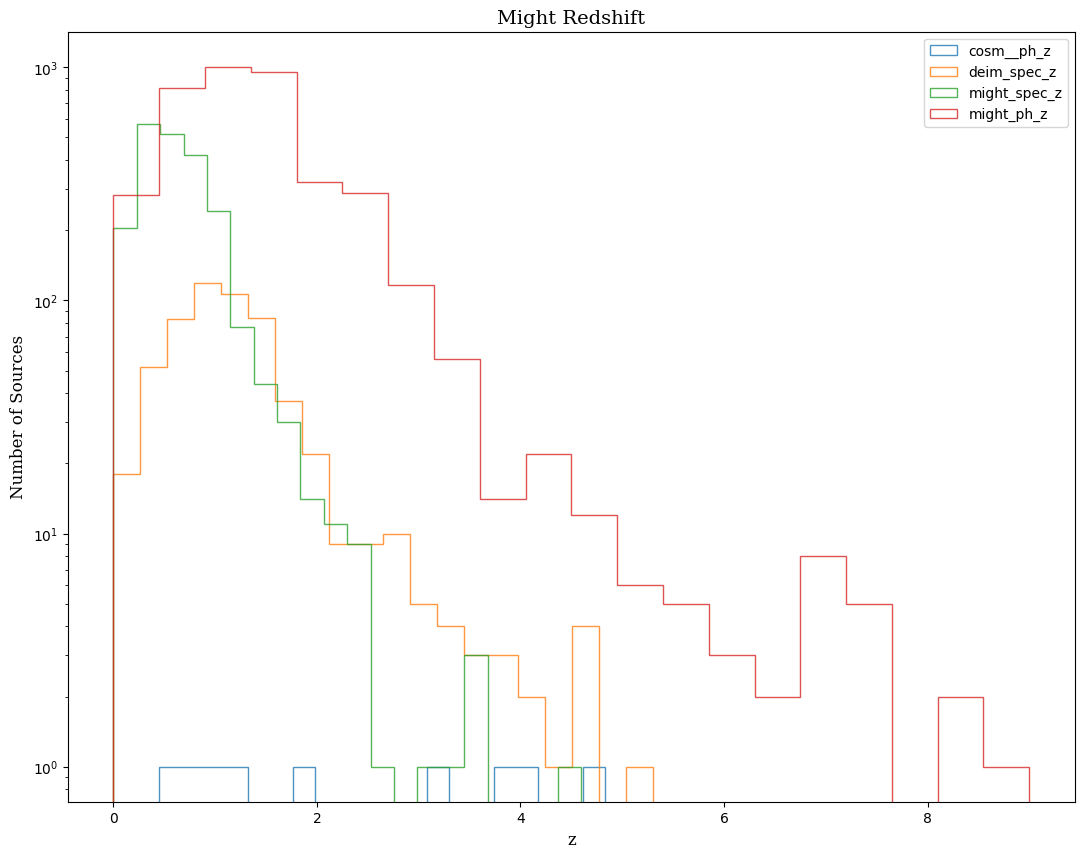

In [ ]:
# and you can control the size of the figure, and font size
plt.figure(figsize=(13,10))

# plot the entire z distribution
#plt.hist( df['z'], bins=20, label="all_z", alpha=0.8, histtype='step')

# plot the z distribution according to origin 
plt.hist( df['z'][df['z_origin'] == 'cosm_ph'] , bins=20, label="cosm__ph_z" , alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'deim_spec'] , bins=20, label="deim_spec_z" , alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'might_spec'], bins=20, label="might_spec_z", alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'might_ph'], bins=20, label="might_ph_z", alpha=0.8, histtype='step')


# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Might Redshift', font='serif', size=14)
plt.xlabel('z', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)
plt.yscale('log')
plt.show()

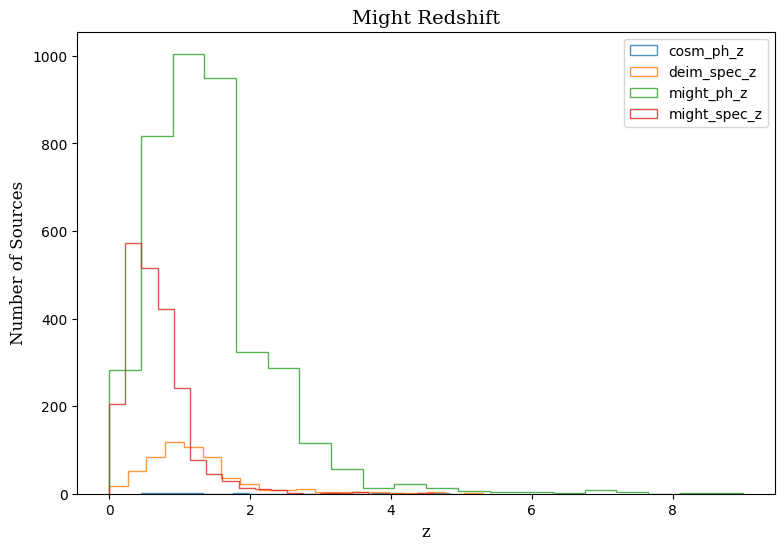

In [ ]:
# plot only Cosmos and Deimos
plt.figure(figsize=(9,6))

# plot the entire z distribution
#plt.hist( df['z'], bins=20, label="all_z", alpha=0.8, histtype='step')

# plot the z distribution according to origin 
plt.hist( df['z'][df['z_origin'] == 'cosm_ph'] , bins=20, label="cosm_ph_z" , alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'deim_spec'] , bins=20, label="deim_spec_z" , alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'might_ph'], bins=20, label="might_ph_z", alpha=0.8, histtype='step')
plt.hist( df['z'][df['z_origin'] == 'might_spec'], bins=20, label="might_spec_z", alpha=0.8, histtype='step')
# to show legend
plt.legend(loc="upper right")

# Add title and axis names
#plt.ylim((0,500))
plt.title('Might Redshift', font='serif', size=14)
plt.xlabel('z', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)
plt.show()

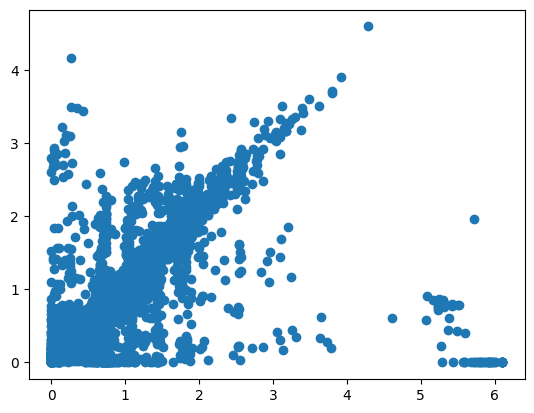

In [ ]:
#dfp = df.drop['specz_redshift']

dfp = dfz3[dfz3['Z_Phot'] >= 0].copy() 

plt.scatter( x= dfp['Z_Phot'][dfp['specz_redshift'] != np.nan] , y = dfp['specz_redshift'][dfp['specz_redshift']!= np.nan] )

In [ ]:
dfselect = dfp[ ( dfp['Z_Phot']>=2.3 ) & ( dfp['specz_redshift'] <= 1.8 )  ]

print(f'Number of sources with large z_ph small z_spec: {dfselect.shape[0]}')
dfselect.head(100)

Number of sources with large z_ph small z_spec: 105


,ra,dec,Z_Phot,specz_redshift
477,150.263610,1.611237,6.1000,0.00047
609,150.559129,1.616189,6.1000,0.00024
14594,150.434315,2.190452,5.9200,0.00085
15525,149.580046,2.221545,6.1000,0.00056
19675,149.696159,2.385567,5.9600,0.00045
...,...,...,...,...
912126,149.411655,2.019497,5.6000,0.00065
912143,149.935675,1.945184,5.8400,0.00031
912172,150.492085,1.920663,5.9600,0.00038
912176,150.781230,1.957582,5.8400,0.00016


## add Imogen flags

Here, we need to: 
* Check if the Might source has a counterpart in Imogen (Note: df has information from Might sources)
* For Might sources with Imogen counterparts, add the Imogen flags

In [ ]:
# dfimo overview
dfimo.head(2)

,CATID,GAUS_ID_NEW,RADIORA,RADIODEC,TOTALFLUX,TOTALFLUXERR,PEAKFLUX,PEAKFLUXERR,MATCHID,NCOMP,OPTICALRA,OPTICALDEC,FLAG,ID,X_IMAGE,Y_IMAGE,RA,DEC,flux_CFHT-u,flux_CFHT-g,flux_CFHT-r,flux_CFHT-iy,flux_CFHT-z,flux_HSC-G,flux_HSC-R,flux_HSC-I,flux_HSC-NB0816,flux_HSC-Z,flux_SC-z,flux_HSC-NB0921,flux_HSC-Y,flux_Y,flux_J,flux_H,flux_Ks,flux_ch1,flux_ch2,err_CFHT-u,err_CFHT-g,err_CFHT-r,err_CFHT-iy,err_CFHT-z,err_HSC-G,err_HSC-R,err_HSC-I,err_HSC-NB0816,err_HSC-Z,err_SC-z,err_HSC-NB0921,err_HSC-Y,err_Y,err_J,err_H,err_Ks,err_ch1,err_ch2,Separation_1,help_id_1,RA_2,Dec_2,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,Separation_1a,HELP_ID_2,RA_1a,Dec_1a,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,Separation_1b,RA_2a,Dec_2a,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_350,n_eff_SPIRE_500,Pval_res_250,Pval_res_350,Pval_res_500,help_id,Separation_1c,ALPHA_J2000,DELTA_J2000,SPLASH_1_FLUX,SPLASH_1_FLUX_ERR,SPLASH_2_FLUX,SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX,SPLASH_4_FLUX_ERR,COS_best_z_v5,COS_best_z_uncertainty_v5,COS_best_z_note_v5,DB_NAME
0,b'COSMOS01779',b'4428 ',150.17317,2.0870,0.000008,0.000004,0.000017,0.000003,423125,1,150.173337,2.087065,100,423125,14949.03125,11958.217773,150.173337,2.087065,2.132264e-30,3.626462e-30,6.896234e-30,1.209006e-29,1.975086e-29,3.543374e-30,7.007174e-30,1.275406e-29,1.352233e-29,2.112831e-29,2.347451e-29,2.295091e-29,3.327049e-29,3.641252e-29,5.117404e-29,7.942099e-29,1.031377e-28,1.522071e-28,1.609172e-28,1.066132e-31,1.813231e-31,3.448117e-31,6.045029e-31,9.875428e-31,1.771687e-31,3.503587e-31,6.377031e-31,6.761166e-31,1.056416e-30,1.173725e-30,1.147546e-30,1.663524e-30,1.820626e-30,2.558702e-30,3.971049e-30,5.156885e-30,7.610357e-30,8.045861e-30,0.000004,b'HELP_J100041.61+020513.49 ...,150.173365,2.087082,53.18071,59.87067,46.335434,-0.016578,0.000005,1.001713,2000.0,0.0,0.117691,b'HELP_J100041.61+020513.49 ...,150.173365,2.087082,1.417843,2.644428,0.446653,3.125101,7.632976,0.864254,0.836862,-1.329415,0.559898,0.03636,0.999368,0.998435,2000.0,2000.0,1.0,0.0,0.117691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b' ',NaN,150.173365,2.087082,16.014811,0.065033,17.292305,0.104621,11.756209,3.483209,8.28536,4.290714,1.0419,0.307225,b'photz ...,imogen
1,b'COSMOS03168',b'2177 ',150.39909,2.2829,0.000011,0.000006,0.000017,0.000004,599607,1,150.399103,2.282885,100,599607,9535.06543,16658.556641,150.399103,2.282885,1.418122e-30,2.564901e-30,6.234591e-30,1.204924e-29,1.160922e-29,2.275892e-30,5.278851e-30,6.701998e-30,6.932147e-30,8.712514e-30,8.198151e-30,8.415049e-30,8.931528e-30,9.342055e-30,1.432293e-29,3.069383e-29,5.022938e-29,1.277240e-28,1.655107e-28,3.396353e-31,1.117533e-30,3.462654e-30,2.376254e-30,6.158427e-30,1.534461e-31,2.639426e-31,3.350999e-31,8.144186e-31,4.356257e-31,4.099075e-31,9.045629e-31,6.498375e-31,7.258107e-31,9.109765e-31,1.534691e-30,2.511469e-30,6.386201e-30,8.275533e-30,0.000011,b' ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b' ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.399168,2.282926,7.231172,9.472713,5.045336,4.613482,8.113111,1.643751,3.864389,8.344719,1.12508,-5.151,-6.728146,-9.521993,1.468991,2.021394,1.151275,1.000164,0.999283,0.999516,1001.0,1001.0,1001.0,0.0,0.0,0.0,b' ',0.276396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3537,0.820103,b'photz ...,imogen


In [ ]:
# add a new column to df to store the Imogen flags
df['imo_flag'] = np.nan

# define object with coordinates from migh cat
c1 = SkyCoord( ra = np.array(df['RA'])*u.deg, dec = np.array(df['DEC'])*u.deg, frame='icrs')

# define object with coordinates from imo cat
c2 = SkyCoord( ra = np.array(dfimo['RADIORA'])*u.deg, dec = np.array(dfimo['RADIODEC'])*u.deg, frame='icrs')

# for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
idx, d2d, d3d = c1.match_to_catalog_sky(c2)

# define max_distance to consider as a true match
max_distance = 2  # arcsec

# keep the index of the c1 objects where there is a match between catalogs
match = np.where(d2d.arcsec <= max_distance) 

# 'match' is a tuple with lists inside it --> store the first list as 'matchlist' 
matchlist = match[0]

# the index of sources from c2 that have a match with c1
idxmatch = idx[match]

for j in range(len(matchlist)): 
  # updated df['imo_flag'] values
  df.at[matchlist[j], 'imo_flag'] = dfimo.at[idxmatch[j], 'FLAG']

# use df.at and dfz.at to specify the index and name_of_column where the values are being read/written: 
# df.at[ index, name_of_column ]

#df.head(20)

In [ ]:
nflag = df['imo_flag'].notnull().sum()
print(f"Number of Might objects that got a Imogen flag: {nflag}")

Number of Might objects that got a Imogen flag: 4013


In [ ]:
######################
# Save the output df #
######################

df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_withz_imoflag_V2.csv")

## add BLOBCAT 3GHz counterparts

Here, we need to:

* Check if the Might source has a counterpart in BLOBCAT 3GHz (Note: df has information from Might sources)


In [ ]:
df.head(2)

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,RESOLVED,ISL_RMS,Fluxfinal,SNR,POINT,DB_NAME,z,z_origin,imo_flag
0,b'J100320.73+020931.7',150.836411,0.00029,2.15882,0.00030,0.000104,0.000029,0.000056,0.000011,1.304066e+09,0.000099,0.000028,0.000053,0.00001,0,0.00001,0.000104,5.550000,1.508368,mightee,NaN,NaN,NaN
1,b'J100320.26+021312.7',150.834427,0.00003,2.22022,0.00008,0.000370,0.000024,0.000248,0.000010,1.304925e+09,0.000353,0.000022,0.000236,0.00001,1,0.00001,0.000370,25.567009,1.059901,mightee,NaN,NaN,NaN


In [ ]:
# read VLA cat and store as a dataframe
dfblob = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/BLOBCAT3GHz.fits', format='fits' )

# store dfvla as a dataframe
dfblob = dfblob.to_pandas()

# add a column with BLOBcat source names

def create_source_name(value):
    return f'BLOB{value}'

dfblob['BLOB_name'] = dfblob['col1'].apply(create_source_name)

# view blobcat columns
dfblob.head(3)

# col33(FLUX)	col34(erroFLUX) are Flux_Peak values in Jy
# col38	col39  are Flux_Int and FLux_Int_err
# col5(RA)	col6(DEC) , ra and dec in deg

,col1,col2,col3,col4,col5(RA),col6(DEC),col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33(FLUX),col34(erroFLUX),col35,col36,col37,col38,col39,col40,col41,BLOB_name
0,1,118,23479,13014,149.647735,2.095481,0.000003,0.000003,23479.51,13013.86,149.647707,2.095473,1,23479.38,13013.71,149.647714,2.095465,1,23474,23485,13008,13020,0.000006,1.0,0.06,2556.0,2618.0,2618.0,0.015312,0.015682,0.015682,0.015682,0.015682,0.000845,0.016141,0.016141,0.016147,0.016147,0.000807,1.07,-1.0,BLOB1
1,2,97,6801,10877,150.574887,1.976763,0.000003,0.000003,6800.97,10877.05,150.574889,1.976766,1,6800.92,10876.84,150.574892,1.976754,1,6796,6806,10872,10882,0.000006,1.0,0.06,2532.0,2532.0,2532.0,0.015489,0.015489,0.015489,0.015489,0.015489,0.000834,0.015596,0.015596,0.015602,0.015602,0.000780,0.88,-1.0,BLOB2
2,3,105,11143,21713,150.333607,2.578821,0.000003,0.000003,11143.16,21712.87,150.333598,2.578813,1,11143.07,21712.64,150.333603,2.578800,1,11138,11149,21707,21718,0.000005,1.0,0.06,2124.0,2145.0,2145.0,0.011065,0.011177,0.011177,0.011177,0.011177,0.000602,0.011364,0.011364,0.011369,0.011369,0.000568,0.98,-1.0,BLOB3


In [ ]:
# read VLA cat and store as a dataframe
dfblob = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/BLOBCAT3GHz.fits', format='fits' )

# store dfvla as a dataframe
dfblob = dfblob.to_pandas()

# add a columns 'BLOB_name' just to have an identifyer for BLOB sources
def create_source_name(value):
    return f'BLOB{value}'

dfblob['BLOB_name'] = dfblob['col1'].apply(create_source_name)

# convert VLA fluxes from uJy to mJy
#dfblob['flux_Jy']     = dfblob['col33(FLUX)']    
#dfblob['flux_err_Jy'] = dfblob['col34(erroFLUX)'] 

dfblob['flux_Jy']     = dfblob['col38']    
dfblob['flux_err_Jy'] = dfblob['col39'] 


# add a new column to df to store the VLA fluxes, VLA_name
df['VLA_name']     = np.nan
df['VLA_ra']       = np.nan
df['VLA_dec']      = np.nan
df['VLA_flux']     = np.nan   # use flux_peak from blobcat and from VLA
df['VLA_flux_err'] = np.nan
df['VLA_rms']      = np.nan
df['VLA_snr']      = np.nan
df['VLA_multi']    = np.nan

# add a column for the radio slope between 1.2 and 3.0 GHz
df['rad_alpha']    = np.nan

# define object with coordinates from migh cat
c1 = SkyCoord( ra = np.array(df['RA'])*u.deg, dec = np.array(df['DEC'])*u.deg, frame='icrs')

# define object with coordinates from imo cat
c2 = SkyCoord( ra = np.array(dfblob['col5(RA)'])*u.deg, dec = np.array(dfblob['col6(DEC)'])*u.deg, frame='icrs')

# for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
idx, d2d, _ = c1.match_to_catalog_sky(c2)

# define max_distance to consider as a true match
max_distance = 2  # arcsec

# keep the index of the c1 objects where there is a match between catalogs
match = np.where(d2d.arcsec <= max_distance) 

# 'match' is a tuple with lists inside it --> store the first list as 'matchlist' 
matchlist = match[0]

# the index of sources from c2 that have a match with c1
idxmatch = idx[match]

for j in range(len(matchlist)): 
  print(f"before: {df.at[matchlist[j], 'VLA_name']}")
  df.at[matchlist[j], 'VLA_name']     = dfblob.at[idxmatch[j], 'BLOB_name']
  df.at[matchlist[j], 'VLA_ra']       = dfblob.at[idxmatch[j], 'col5(RA)'  ]
  df.at[matchlist[j], 'VLA_dec']      = dfblob.at[idxmatch[j], 'col6(DEC)' ]
  df.at[matchlist[j], 'VLA_flux']     = dfblob.at[idxmatch[j], 'col38']
  df.at[matchlist[j], 'VLA_flux_err'] = dfblob.at[idxmatch[j], 'col39']
  print(f"after: {df.at[matchlist[j], 'VLA_name']}")


# use df.at and dfz.at to specify the index and name_of_column where the values are being read/written: 
# df.at[ index, name_of_column ]

nblob = df['VLA_name'].notnull().sum()
print(f"Number of Might objects that got a BLOB counterpart: {nblob}")

Streaming output truncated to the last 5000 lines.
after: BLOB9156
before: nan
after: BLOB7223
before: nan
after: BLOB1288
before: nan
after: BLOB3367
before: nan
after: BLOB10438
before: nan
after: BLOB2910
before: nan
after: BLOB8682
before: nan
after: BLOB7575
before: nan
after: BLOB6096
before: nan
after: BLOB6501
before: nan
after: BLOB6452
before: nan
after: BLOB4018
before: nan
after: BLOB6140
before: nan
after: BLOB4427
before: nan
after: BLOB10216
before: nan
after: BLOB9017
before: nan
after: BLOB2221
before: nan
after: BLOB637
before: nan
after: BLOB3080
before: nan
after: BLOB2738
before: nan
after: BLOB7139
before: nan
after: BLOB2066
before: nan
after: BLOB17492
before: nan
after: BLOB6921
before: nan
after: BLOB9201
before: nan
after: BLOB6448
before: nan
after: BLOB9969
before: nan
after: BLOB2602
before: nan
after: BLOB10570
before: nan
after: BLOB1488
before: nan
after: BLOB3235
before: nan
after: BLOB7753
before: nan
after: BLOB2598
before: nan
after: BLOB1310
before

In [ ]:
######################
# Save the output df #
######################

df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_withz_imoflag_BLOB.csv")

In [ ]:
df.head()

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,RESOLVED,ISL_RMS,Fluxfinal,SNR,POINT,DB_NAME,z,z_origin,imo_flag,VLA_name,VLA_ra,VLA_dec,VLA_flux,VLA_flux_err,VLA_rms,VLA_snr,VLA_multi,rad_alpha
0,b'J100320.73+020931.7',150.836411,0.00029,2.15882,0.00030,0.000104,0.000029,0.000056,0.000011,1.304066e+09,0.000099,0.000028,0.000053,0.000010,0,0.000010,0.000104,5.550000,1.508368,mightee,NaN,NaN,NaN,b'COSMOSVLA3 J100320.72+020933.5',150.836358,2.159314,0.000020,0.000004,3.87,5.09,0.0,1.951092
1,b'J100320.26+021312.7',150.834427,0.00003,2.22022,0.00008,0.000370,0.000024,0.000248,0.000010,1.304925e+09,0.000353,0.000022,0.000236,0.000010,1,0.000010,0.000370,25.567009,1.059901,mightee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'J100319.37+021447.2',150.830734,0.00011,2.24645,0.00013,0.000075,0.000016,0.000079,0.000009,1.305699e+09,0.000071,0.000015,0.000075,0.000009,0,0.000010,0.000079,8.177083,1.295495,mightee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'J100318.49+021000.5',150.827057,0.00016,2.16682,0.00021,0.000061,0.000018,0.000058,0.000010,1.306541e+09,0.000058,0.000017,0.000056,0.000009,0,0.000010,0.000061,5.878788,1.469013,mightee,NaN,NaN,NaN,b'COSMOSVLA3 J100318.49+021001.6',150.827043,2.167138,0.000024,0.000004,3.41,7.11,0.0,1.081579
4,b'J100317.73+021606.7',150.823883,0.00007,2.26855,0.00008,0.000164,0.000019,0.000142,0.000010,1.306922e+09,0.000156,0.000018,0.000135,0.000009,0,0.000009,0.000164,15.095745,1.125254,mightee,NaN,NaN,NaN,b'COSMOSVLA3 J100317.74+021606.7',150.823942,2.268542,0.000066,0.000005,3.58,5.38,0.0,1.070765


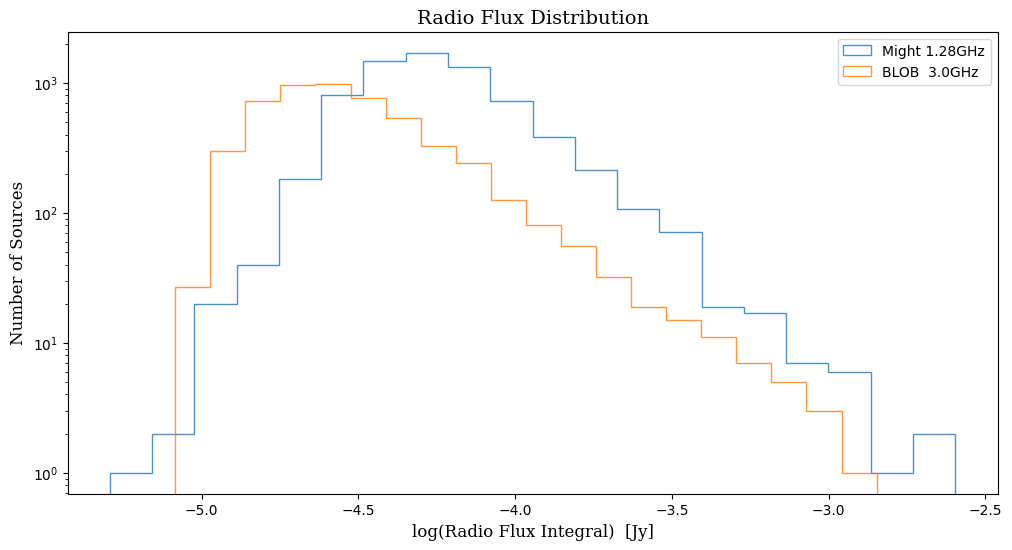

In [ ]:
# plot flux distribution
plt.figure(figsize=(12,6))

# plot the entire z distribution
#plt.hist( df['z'], bins=20, label="all_z", alpha=0.8, histtype='step')

# plot the z distribution according to origin 
plt.hist( np.log10(df['S_INT'])    , bins=20, label="Might 1.28GHz"   , alpha=0.8, histtype='step')

# here, VLA_flux has only fluxes from BLOBCAT (peak_flux)
plt.hist( np.log10(df['VLA_flux']) , bins=20, label="BLOB  3.0GHz" , alpha=0.8, histtype='step')
#plt.hist( df['z'][df['z_origin'] == 'other'], bins=20, label="other_z", alpha=0.8, histtype='step')

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Radio Flux Distribution', font='serif', size=14)
plt.xlabel('log(Radio Flux Integral)  [Jy]', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

# set loglog scale
#plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
# DID NOT CALCULATE ALPHAS YET #
# but... can calculate, see how the alphas behave only with blob fluxes 

# plot alpha distribution
plt.figure(figsize=(9,6))

# set range, number of bins for the histogram 
plt.hist( df['rad_alpha'], range=[-2,3], bins=20, label="1.2-3 GHz slope" , alpha=0.8, histtype='step')

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Radio Slope Distribution', font='serif', size=14)
plt.xlabel('Radio Slope [1.2 to 3.0 GHz]', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

plt.show()

## add VLA 3GHz counterparts

Here, we need to:

* Check if the Might source has a counterpart in VLA 3GHz (Note: df has information from Might sources)
* For Might sources with VLA counterparts, calculate a radio slope: alpha_1.2_3.0 

In [ ]:
df.head(2)

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,RESOLVED,ISL_RMS,Fluxfinal,SNR,POINT,DB_NAME,z,z_origin,S_I/P,imo_flag
0,b'J100319.37+021447.2',150.830734,0.00011,2.24645,0.00013,0.000075,0.000016,0.000079,0.000009,1.305699e+09,0.000071,0.000015,0.000075,0.000009,0,0.00001,0.000079,8.177083,1.295495,mightee,NaN,NaN,0.954140,NaN
1,b'J100318.49+021000.5',150.827057,0.00016,2.16682,0.00021,0.000061,0.000018,0.000058,0.000010,1.306541e+09,0.000058,0.000017,0.000056,0.000009,0,0.00001,0.000061,5.878788,1.469013,mightee,NaN,NaN,1.044674,NaN


In [ ]:
dfbackup = df.copy()

In [ ]:
# read VLA cat and store as a dataframe
dfvla = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/VLA3GHz-Cosmos.fits', format='fits' )

# store dfvla as a dataframe
dfvla = dfvla.to_pandas()

# view dfvla
dfvla.head()

,id,name,ra,ra_err,dec,dec_err,flux,flux_err,rms,snr,npix,res,multi
0,2237,b'COSMOSVLA3 J095935.90+024137.5',149.899593,0.036,2.693750,0.036,40.8,3.0,2.25,15.70,36,1,0
1,262,b'COSMOSVLA3 J095935.96+024458.7',149.899836,0.011,2.749640,0.011,293.0,16.0,2.30,127.00,57,0,0
2,10127,b'COSMOSVLA3 J095935.97+022044.5',149.899876,0.100,2.345704,0.100,12.0,2.4,2.29,5.23,18,0,0
3,10211,b'COSMOSVLA3 J095935.97+023925.4',149.899882,0.110,2.657072,0.110,20.2,2.6,2.42,5.09,20,1,0
4,8232,b'COSMOSVLA3 J095935.98+014955.4',149.899956,0.091,1.832060,0.091,13.1,2.3,2.22,5.92,14,0,0


In [ ]:
# read VLA cat and store as a dataframe
dfvla = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/VLA3GHz-Cosmos.fits', format='fits' )

# store dfvla as a dataframe
dfvla = dfvla.to_pandas()

# convert VLA fluxes from uJy to mJy
dfvla['flux_Jy']     = dfvla['flux']     / 1E6   # This is Flux Peak in uJy
dfvla['flux_err_Jy'] = dfvla['flux_err'] / 1E6

# This columns are already created in the last cell
# add a new column to df to store the VLA fluxes, VLA_name
df['VLA_name']     = np.nan
df['VLA_ra']       = np.nan
df['VLA_dec']      = np.nan
df['VLA_flux']     = np.nan
df['VLA_flux_err'] = np.nan
df['VLA_rms']      = np.nan
df['VLA_snr']      = np.nan
df['VLA_multi']    = np.nan

# add a column for the radio slope between 1.2 and 3.0 GHz
df['rad_alpha']    = np.nan

# define object with coordinates from migh cat
c1 = SkyCoord( ra = np.array(df['RA'])*u.deg, dec = np.array(df['DEC'])*u.deg, frame='icrs')

# define object with coordinates from imo cat
c2 = SkyCoord( ra = np.array(dfvla['ra'])*u.deg, dec = np.array(dfvla['dec'])*u.deg, frame='icrs')

# for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
idx, d2d, d3d = c1.match_to_catalog_sky(c2)

# define max_distance to consider as a true match
max_distance = 2  # arcsec

# keep the index of the c1 objects where there is a match between catalogs
match = np.where(d2d.arcsec <= max_distance) 

# 'match' is a tuple with lists inside it --> store the first list as 'matchlist' 
matchlist = match[0]

# the index of sources from c2 that have a match with c1
idxmatch = idx[match]

for j in range(len(matchlist)): 
  # updated df['VLA_xxx'] values only if dfvla['multi'] = 0 
  if dfvla.at[ idxmatch[j], 'multi'] == 0:
    print(f"before: {df.at[matchlist[j], 'VLA_name']}")
    df.at[matchlist[j], 'VLA_name']     = dfvla.at[idxmatch[j], 'name']
    df.at[matchlist[j], 'VLA_ra']       = dfvla.at[idxmatch[j], 'ra'  ]
    df.at[matchlist[j], 'VLA_dec']      = dfvla.at[idxmatch[j], 'dec' ]
    df.at[matchlist[j], 'VLA_flux']     = dfvla.at[idxmatch[j], 'flux_Jy']
    df.at[matchlist[j], 'VLA_flux_err'] = dfvla.at[idxmatch[j], 'flux_err_Jy']
    df.at[matchlist[j], 'VLA_rms']      = dfvla.at[idxmatch[j], 'rms']
    df.at[matchlist[j], 'VLA_snr']      = dfvla.at[idxmatch[j], 'snr']
    # just to check:
    df.at[matchlist[j], 'VLA_multi']    = dfvla.at[idxmatch[j], 'multi']
    print(f"after: {df.at[matchlist[j], 'VLA_name']}")


# calculate radio slopes between 1.2 and 3.0 VLA3GHz
for i in range(len(df)):
  # calculate slopes only if VLA_flux data is available
  if df['VLA_flux'][i] >= 0:
    df.at[i, 'rad_alpha'] = (1) * np.log10( df.at[i, 'VLA_flux'] / df.at[i, 'S_INT'] ) / np.log10( 3 / 1.28 )

# use df.at and dfz.at to specify the index and name_of_column where the values are being read/written: 
# df.at[ index, name_of_column ]

nvla = df['VLA_name'].notnull().sum()
print(f"Number of Might objects that got a VLA counterpart: {nvla}")

Streaming output truncated to the last 5000 lines.
after: b'COSMOSVLA3 J100045.88+020650.7'
before: nan
after: b'COSMOSVLA3 J100042.61+021229.0'
before: nan
after: b'COSMOSVLA3 J100043.52+021223.7'
before: nan
after: b'COSMOSVLA3 J100044.09+021225.5'
before: nan
after: b'COSMOSVLA3 J100046.07+024944.8'
before: nan
after: b'COSMOSVLA3 J100045.24+015458.7'
before: nan
after: b'COSMOSVLA3 J100045.54+023915.0'
before: nan
after: b'COSMOSVLA3 J100045.32+015904.6'
before: nan
after: b'COSMOSVLA3 J100045.26+015823.2'
before: nan
after: b'COSMOSVLA3 J100045.10+022110.5'
before: nan
after: b'COSMOSVLA3 J100045.17+024132.8'
before: nan
after: b'COSMOSVLA3 J100045.07+020806.0'
before: nan
after: b'COSMOSVLA3 J100044.91+025423.3'
before: nan
after: b'COSMOSVLA3 J100044.98+013013.9'
before: nan
after: b'COSMOSVLA3 J100044.91+022248.6'
before: nan
after: b'COSMOSVLA3 J100044.92+021405.2'
before: nan
after: b'COSMOSVLA3 J100044.61+015553.4'
before: nan
after: b'COSMOSVLA3 J100044.66+013431.6'
before:

In [ ]:
######################
# Save the output df #
######################

df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_withz_imoflag_VLA_V2.csv")

In [ ]:
# Check: Some cases will have counterpart from VLA and some from BLOBcat
print(df[{'VLA_name','VLA_flux'}].to_string())

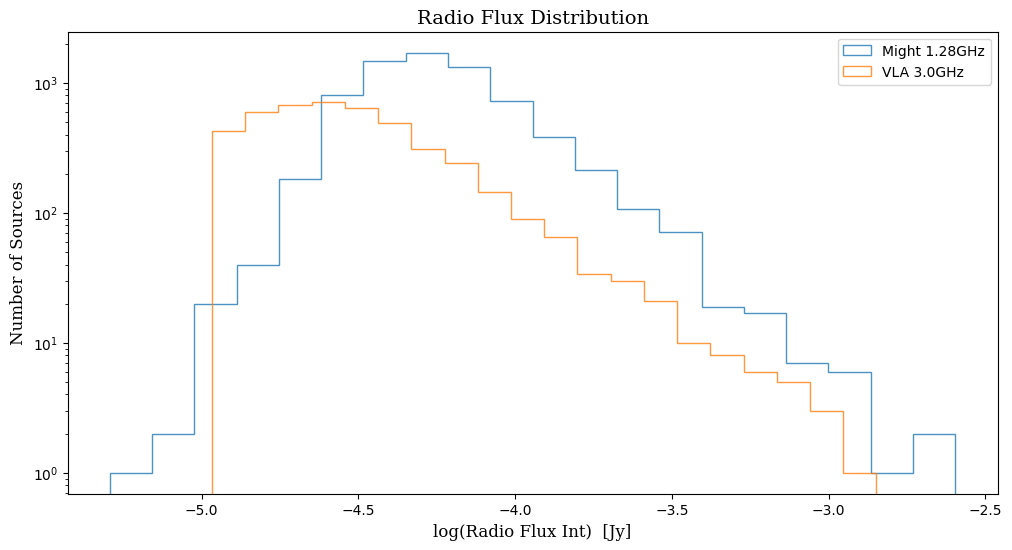

In [ ]:
# plot flux distribution
plt.figure(figsize=(12,6))

# plot the entire z distribution
#plt.hist( df['z'], bins=20, label="all_z", alpha=0.8, histtype='step')

# plot the z distribution according to origin 
plt.hist( np.log10(df['S_INT'])    , bins=20, label="Might 1.28GHz"   , alpha=0.8, histtype='step')
plt.hist( np.log10(df['VLA_flux']) , bins=20, label="VLA 3.0GHz" , alpha=0.8, histtype='step')
#plt.hist( np.log10(df['VLA_flux']) , bins=20, label="VLA + BLOB 3.0GHz" , alpha=0.8, histtype='step')
#plt.hist( df['z'][df['z_origin'] == 'other'], bins=20, label="other_z", alpha=0.8, histtype='step')

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Radio Flux Distribution', font='serif', size=14)
plt.xlabel('log(Radio Flux Int)  [Jy]', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

# set loglog scale
#plt.xscale('log')
plt.yscale('log')

plt.show()

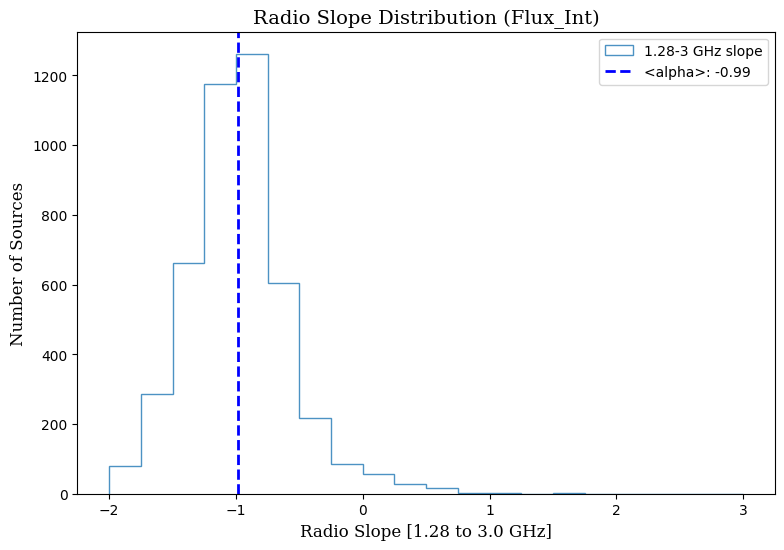

In [ ]:
# plot alpha distribution
plt.figure(figsize=(9,6))

# set range, number of bins for the histogram 
plt.hist( df['rad_alpha'], range=[-2,3], bins=20, label="1.28-3 GHz slope" , alpha=0.8, histtype='step')

# calculate a mean value for alpha 
alpha_mean = df['rad_alpha'].mean()

# add line with alpha_mean value
plt.axvline(x = alpha_mean, color = 'b', ls='--', lw=2, label = f"<alpha>: {alpha_mean:.2f}")

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Radio Slope Distribution (Flux_Int)', font='serif', size=14)
plt.xlabel('Radio Slope [1.28 to 3.0 GHz]', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

plt.show()

In [ ]:
# number of sources used
nradio = df['VLA_name'].notnull().sum()
print(f"The number of sources used: {nradio}")

The number of sources used: 7029


## add Spitzer Cosmos

In [ ]:
# view dfcosm columns
dfcosm = pd.read_parquet('/content/drive/MyDrive/data/Module_DataWrang_2023_data/Cosmos-Classic-Cat2020.parquet')

dfcosm.head(3)

,id,ra,dec,cfht_u_flux_auto,cfht_u_fluxerr_auto,cfht_u_mag_auto,cfht_u_magerr_auto,cfht_u_flags,cfht_u_imaflags_iso,cfht_ustar_flux_auto,cfht_ustar_fluxerr_auto,cfht_ustar_flags,cfht_ustar_imaflags_iso,hsc_g_flux_auto,hsc_g_fluxerr_auto,hsc_g_mag_auto,hsc_g_magerr_auto,hsc_g_imaflags_iso,hsc_r_flux_aper2,hsc_r_flux_auto,hsc_r_fluxerr_auto,hsc_r_mag_auto,hsc_r_magerr_auto,hsc_r_flags,hsc_r_imaflags_iso,hsc_i_flux_auto,hsc_i_fluxerr_auto,hsc_i_mag_auto,hsc_i_magerr_auto,hsc_i_flags,hsc_i_imaflags_iso,hsc_z_flux_auto,hsc_z_fluxerr_auto,hsc_z_mag_auto,hsc_z_magerr_auto,hsc_z_flags,hsc_z_imaflags_iso,hsc_y_flux_auto,hsc_y_fluxerr_auto,hsc_y_mag_auto,hsc_y_magerr_auto,hsc_y_flags,hsc_y_imaflags_iso,uvista_y_flux_auto,uvista_y_fluxerr_auto,uvista_y_mag_auto,uvista_y_magerr_auto,uvista_y_flags,uvista_y_imaflags_iso,uvista_j_flux_auto,uvista_j_fluxerr_auto,uvista_j_mag_auto,uvista_j_magerr_auto,uvista_j_flags,uvista_j_imaflags_iso,uvista_h_flux_auto,uvista_h_fluxerr_auto,uvista_h_mag_auto,uvista_h_magerr_auto,uvista_h_flags,uvista_h_imaflags_iso,uvista_ks_flux_auto,uvista_ks_fluxerr_auto,uvista_ks_mag_auto,uvista_ks_magerr_auto,uvista_ks_flags,uvista_ks_imaflags_iso,id_galex,galex_fuv_flux,galex_fuv_fluxerr,galex_fuv_mag,galex_fuv_magerr,galex_nuv_flux,galex_nuv_fluxerr,galex_nuv_mag,galex_nuv_magerr,splash_ch1_flux,splash_ch1_fluxerr,splash_ch1_mag,splash_ch1_magerr,splash_ch2_flux,splash_ch2_fluxerr,splash_ch2_mag,splash_ch2_magerr,splash_ch3_flux,splash_ch3_fluxerr,splash_ch3_mag,splash_ch3_magerr,splash_ch4_flux,splash_ch4_fluxerr,splash_ch4_mag,splash_ch4_magerr,acs_f814w_flux,acs_f814w_fluxerr,acs_f814w_mag,acs_f814w_magerr,acs_mu_max,acs_mu_class
0,1409059,149.236075,2.762807,0.032,0.007,27.6438,0.2235,0,0,0.038,0.009,0.0,0.0,0.065,0.006,26.8728,0.0983,0,0.095,0.095,0.008,26.4604,0.0956,0,0,0.089,0.010,26.5276,0.1234,0,0,0.098,0.016,26.4242,0.1798,0,0,0.032,0.043,27.6217,1.4499,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1409060,149.466550,2.762960,0.002,0.010,30.9491,7.0229,0,0,0.009,0.013,0.0,0.0,0.054,0.008,27.0749,0.1606,0,0.045,0.060,0.011,26.9561,0.1966,0,0,0.032,0.013,27.6215,0.4184,0,0,0.045,0.021,27.2622,0.5161,0,0,0.038,0.046,27.4632,1.3183,0,0,-0.041,0.021,NaN,NaN,0.0,0.0,0.09,0.026,26.5187,0.3197,0.0,0.0,0.048,0.036,27.2019,0.8251,0.0,0.0,-0.042,0.059,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1409118,150.960164,2.762494,0.130,0.011,26.1180,0.0920,2,0,0.142,0.033,2.0,0.0,0.213,0.011,25.5793,0.0571,0,0.184,0.257,0.018,25.3768,0.0772,2,0,0.297,0.021,25.2183,0.0766,2,0,0.377,0.034,24.9588,0.0978,2,0,0.291,0.087,25.2416,0.3261,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# read VLA cat and store as a dataframe
#dfcosmos = Table.read('/content/drive/MyDrive/data/Module_DataWrang_2023_data/CosmosClassic.fits', format='fits' )

dfcosm = pd.read_parquet('/content/drive/MyDrive/data/Module_DataWrang_2023_data/Cosmos-Classic-Cat2020.parquet')

# add a new column to df to store the VLA fluxes, VLA_name
df['Cosm_id']       = np.nan
df['Cosm_ra']       = np.nan
df['Cosm_dec']      = np.nan
df['Cosm_CH1flux']     = np.nan
df['Cosm_CH1flux_err'] = np.nan
df['Cosm_CH2flux']     = np.nan
df['Cosm_CH2flux_err'] = np.nan
df['Cosm_CH3flux']     = np.nan
df['Cosm_CH3flux_err'] = np.nan
df['Cosm_CH4flux']     = np.nan
df['Cosm_CH4flux_err'] = np.nan

# define object with coordinates from migh cat
c1 = SkyCoord( ra = np.array(df['RA'])*u.deg, dec = np.array(df['DEC'])*u.deg, frame='icrs')

# define object with coordinates from imo cat
c2 = SkyCoord( ra = np.array(dfcosm['ra'])*u.deg, dec = np.array(dfcosm['dec'])*u.deg, frame='icrs')

# for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
idx, d2d, d3d = c1.match_to_catalog_sky(c2)

# define max_distance to consider as a true match
max_distance = 2  # arcsec

# keep the index of the c1 objects where there is a match between catalogs
match = np.where(d2d.arcsec <= max_distance) 

# 'match' is a tuple with lists inside it --> store the first list as 'matchlist' 
matchlist = match[0]

# the index of sources from c2 that have a match with c1
idxmatch = idx[match]

for j in range(len(matchlist)): 
  # updated df['Cosm_xxx'] values 
  df.at[matchlist[j], 'Cosm_id']          = dfcosm.at[idxmatch[j], 'id']
  df.at[matchlist[j], 'Cosm_ra']          = dfcosm.at[idxmatch[j], 'ra'  ]
  df.at[matchlist[j], 'Cosm_dec']         = dfcosm.at[idxmatch[j], 'dec' ]
  df.at[matchlist[j], 'Cosm_CH1flux']     = dfcosm.at[idxmatch[j], 'splash_ch1_flux']
  df.at[matchlist[j], 'Cosm_CH1flux_err'] = dfcosm.at[idxmatch[j], 'splash_ch1_fluxerr']
  df.at[matchlist[j], 'Cosm_CH2flux']     = dfcosm.at[idxmatch[j], 'splash_ch2_flux']
  df.at[matchlist[j], 'Cosm_CH2flux_err'] = dfcosm.at[idxmatch[j], 'splash_ch2_fluxerr']
  df.at[matchlist[j], 'Cosm_CH3flux']     = dfcosm.at[idxmatch[j], 'splash_ch3_flux']
  df.at[matchlist[j], 'Cosm_CH3flux_err'] = dfcosm.at[idxmatch[j], 'splash_ch3_fluxerr']
  df.at[matchlist[j], 'Cosm_CH4flux']     = dfcosm.at[idxmatch[j], 'splash_ch4_flux']
  df.at[matchlist[j], 'Cosm_CH4flux_err'] = dfcosm.at[idxmatch[j], 'splash_ch4_fluxerr']


# add a column for the IR and Radio-IR slopes
df['CH1_CH2_alpha']      = np.nan
df['CH2_CH3_alpha']      = np.nan
df['rMight_CH2_alpha']   = np.nan
df['rVLA_CH2_alpha']     = np.nan

# nu values
lCH1 = 3.6
lCH2 = 4.5 
lCH3 = 5.8 
lCH4 = 8.0 

# light speed
c = 2.99792E8

# calculate radio slopes between 1.2 and 3.0 VLA3GHz
# Note: Cosmos fluxes are in [uJy] and Radio fluxes are in [Jy]
for i in range(len(df)):
  # calculate slopes onle when haveing an if (i.e. a Sptizer counterpart)
  if df.at[i, 'Cosm_id'] >= 0:
    # calculate slopes 
    df.at[i, 'CH1_CH2_alpha'] = (-1) * np.log10( df.at[i, 'Cosm_CH1flux'] /  df.at[i, 'Cosm_CH2flux'] ) / np.log10( lCH2 / lCH1 )
    df.at[i, 'CH2_CH3_alpha'] = (-1) * np.log10( df.at[i, 'Cosm_CH2flux'] /  df.at[i, 'Cosm_CH3flux'] ) / np.log10( lCH3 / lCH2 )
    df.at[i, 'rMight_CH2_alpha'] = (-1) * np.log10( df.at[i, 'S_INT'    ] / (df.at[i, 'Cosm_CH2flux'] * 1E-6) ) / np.log10( 1.2E9 / (c / (lCH2*1E-6) ) )
    df.at[i, 'rVLA_CH2_alpha']   = (-1) * np.log10( df.at[i, 'VLA_flux' ] / (df.at[i, 'Cosm_CH2flux'] * 1E-6) ) / np.log10( 3.0E9 / (c / (lCH2*1E-6) ) )


# use df.at and dfz.at to specify the index and name_of_column where the values are being read/written: 
# df.at[ index, name_of_column ]

ncosm = df['Cosm_id'].notnull().sum()
print(f"Number of Might objects that got a Cosmos2020-Spitzer counterpart: {ncosm}")

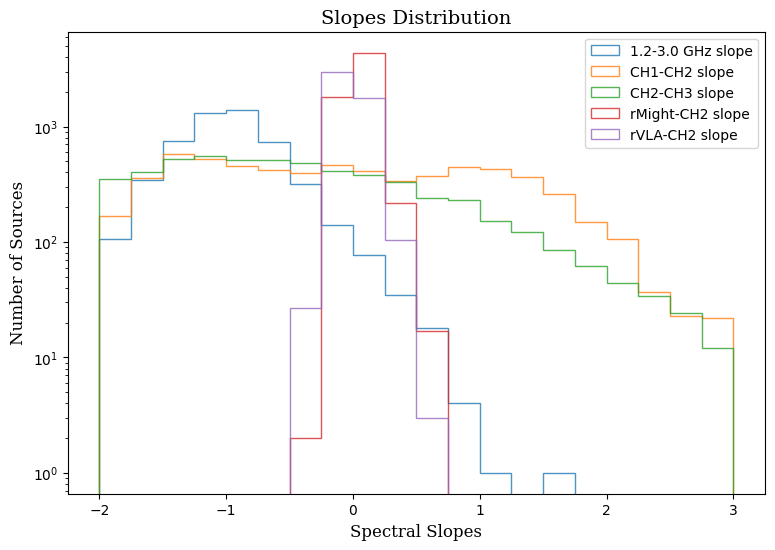

In [ ]:
# plot alpha distribution
plt.figure(figsize=(9,6))

# set range, number of bins for the histogram 
plt.hist( df['rad_alpha'],        range=[-2,3], bins=20, label="1.2-3.0 GHz slope" , alpha=0.8, histtype='step')
plt.hist( df['CH1_CH2_alpha'],    range=[-2,3], bins=20,     label="CH1-CH2 slope" , alpha=0.8, histtype='step')
plt.hist( df['CH2_CH3_alpha'],    range=[-2,3], bins=20,     label="CH2-CH3 slope" , alpha=0.8, histtype='step')
plt.hist( df['rMight_CH2_alpha'], range=[-2,3], bins=20,  label="rMight-CH2 slope" , alpha=0.8, histtype='step')
plt.hist( df['rVLA_CH2_alpha'],   range=[-2,3], bins=20,    label="rVLA-CH2 slope" , alpha=0.8, histtype='step')


# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Slopes Distribution', font='serif', size=14)
plt.xlabel('Spectral Slopes', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

# set log axis 
plt.yscale('log')

plt.show()

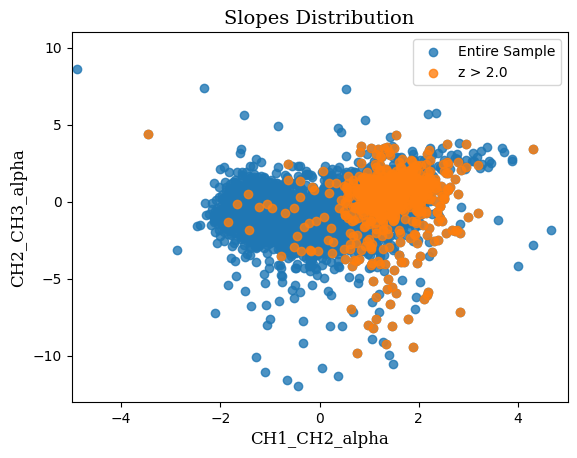

In [ ]:
# plot for the entire sample
plt.scatter( x = df['CH1_CH2_alpha'], y = df['CH2_CH3_alpha'] , alpha=0.8, label="Entire Sample")

# define a z_limit
z_lim = 2.0

# plot the subsample with z > z_lim
plt.scatter( x = df['CH1_CH2_alpha'][df['z'] > z_lim ] , y = df['CH2_CH3_alpha'][df['z'] > z_lim ] , alpha=0.8, label=f"z > {z_lim}")

# set plot limits
plt.xlim(-5,5)
plt.ylim(-13,11)

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title('Slopes Distribution', font='serif', size=14)
plt.xlabel('CH1_CH2_alpha', font='serif', size=12)
plt.ylabel('CH2_CH3_alpha', font='serif', size=12)

plt.show()


In [ ]:
######################
# Save the output df #
######################

df.to_csv(f"{datapath_wrang}/autodf/dfmig_PSC_withz_imoflag_VLA_Sptizer.csv")

## Add IR counterparts (from Vizier) (**need update of column names**)

In [ ]:
# add IR counterparts

# read the input (cat1) table / or read the objects from your new sample in df_new
#input_table = Table.read(f"/content/drive/MyDrive/data/Module_DataWrang_2023_data/dfnew2.csv")
input_table = Table.from_pandas(df)

XMatch.TIMEOUT = 150 

# for CatWISE2020
#vizier_cat =  'vizier:II/365/catwise'

# for AllWISE catalog
vizier_cat = 'vizier:II/328/allwise'

matched_table = XMatch.query(cat1=input_table, cat2= vizier_cat , max_distance=2.0 * u.arcsec,  
                     colRA1='ra', colDec1='dec',         # The name of the RA , DEC columns in your df 
                     all_columns=True, selection='all') # selection='best' or 'all'  

# select columns from AllWISE that will be kept ; 'columns_to_select' came from  
match_columns = columns_to_select + ['AllWISE','RAJ2000','DEJ2000','W1mag','W2mag','W3mag','W4mag','qph']

matched_table = matched_table[match_columns]

# select only few columns
#columns = ['RA', 'DEC', 'other-columns-of-interest']
#output_table = Table(output_table[columns])

# Print table colums (use to select columns to keep)
print(f"The output_table has {len(matched_table)} sources. \nOnly the input sources that have a match")
#output_table.columns

# convert Astropy Table to pandas df 
dfwise = matched_table.to_pandas()

display(dfwise.head(3))

In [ ]:
###########################################
# Update table to keep all input sources  #
# With and WIthout IR matches             #
###########################################

# Convert the input_table and matched_table to a pandas DataFrame
input_df   = input_table.to_pandas()
matched_df = matched_table.to_pandas()

# Rename the columns in matched_df to avoid conflicts when merging
column_mapping = {
    'AllWISE': 'WISE_name',
    'RAJ2000': 'WISE_ra',
    'DEJ2000': 'WISE_dec',
    'W1mag': 'WISE_W1mag',
    'W2mag': 'WISE_W2mag',
    'W3mag': 'WISE_W3mag',
    'W4mag': 'WISE_W4mag',
    'qph': 'WISE_qph'
}
matched_df.rename(columns=column_mapping, inplace=True)

# define the columns that will be used for merging
columns_to_merge = ['name', 'ra', 'dec', 'flux_int', 'flux_int_err', 'flux_peak', 'flux_peak_err']
#columns_to_merge = ['name', 'ra', 'dec']


# Merge the input_table (pandas DataFrame) with the matched_df using 'columns_to_merge' as reference from both cats
output_df = pd.merge(input_df, matched_df, left_on=columns_to_merge, right_on=columns_to_merge, how='left')

# Select the desired output columns
#output_columns = columns_to_select + ['AllWISE', 'WISE_RA', 'WISE_DEC', 'WISE_W1mag', 'WISE_W2mag', 'WISE_W3mag', 'WISE_W4mag', 'WISE_qph']
#output_df = output_df[output_columns]

output_df

,name,ra,dec,flux_int,flux_int_err,flux_peak,flux_peak_err,WISE_name,WISE_ra,WISE_dec,WISE_W1mag,WISE_W2mag,WISE_W3mag,WISE_W4mag,WISE_qph
0,J100320.73+020931.7,150.836411,2.158820,0.000104,0.000029,0.000056,0.000011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J100320.26+021312.7,150.834427,2.220220,0.000370,0.000024,0.000248,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J100319.37+021447.2,150.830734,2.246450,0.000075,0.000016,0.000079,0.000009,J100319.42+021447.4,150.830952,2.246520,16.170,16.180,12.033,8.892,ABBU
3,J100318.49+021000.5,150.827057,2.166820,0.000061,0.000018,0.000058,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J100317.73+021606.7,150.823883,2.268550,0.000164,0.000019,0.000142,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,COSMOS02319,149.612245,2.164687,0.000035,0.000012,0.000039,0.000007,J095826.84+020952.2,149.611857,2.164512,17.376,16.991,11.968,8.910,BCUU
9904,COSMOS02658,149.607014,2.216952,0.000043,0.000012,0.000047,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9905,COSMOS02473,149.605692,2.190108,0.000048,0.000013,0.000046,0.000007,J095825.41+021125.4,149.605898,2.190389,16.000,15.833,11.643,8.562,ABUU
9906,COSMOS02914,149.604801,2.248996,0.000152,0.000013,0.000151,0.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# save output_df: the table with (might + imogen) x AllWise
# Davi, you need to update the location to point to a folder in your drive
output_df.to_csv(f"/content/drive/MyDrive/data/Module_DataWrang_2023_data/MightImo-x-AllWISE.csv", index=False)

In [ ]:
# if you crossmatch with AllWISE
print(f"Number of sources with no AllWISE counterpart:")
output_df['WISE_ra'].isnull().sum()

Number of sources with no IR counterpart:


5014

In [ ]:
# if you match with CatWISE2020   : update column names in the crossmatch cell
print(f"Number of sources with no CatWISE2020 counterpart:")
output_df['xxxxx_ra'].isnull().sum()

## Clean Sample & Plot alpha dist




In [ ]:
dfclean1 = df[ df['imo_flag'].between(100,105)  ].copy() 

dfclean1.shape[0]

3968

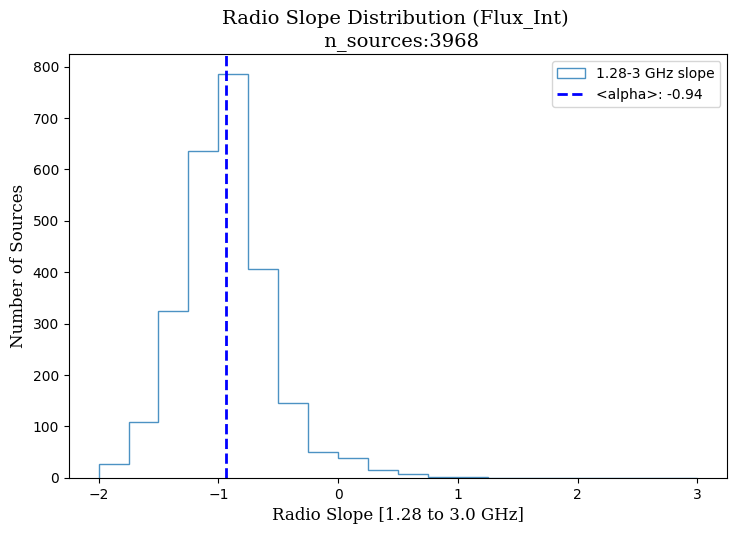

In [ ]:
dfplot = dfclean1.copy()

# plot alpha distribution
plt.figure(figsize=(8.5,5.5))

# set range, number of bins for the histogram 
plt.hist( dfplot['rad_alpha'], range=[-2,3], bins=20, label="1.28-3 GHz slope" , alpha=0.8, histtype='step')

# calculate a mean value for alpha 
alpha_mean = dfplot['rad_alpha'].mean()

# add line with alpha_mean value
plt.axvline(x = alpha_mean, color = 'b', ls='--', lw=2, label = f"<alpha>: {alpha_mean:.2f}")

# to show legend
plt.legend(loc="upper right")

# Add title and axis names
plt.title(f"Radio Slope Distribution (Flux_Int) \n n_sources:{dfplot.shape[0]}", font='serif', size=14)
plt.xlabel('Radio Slope [1.28 to 3.0 GHz]', font='serif', size=12)
plt.ylabel('Number of Sources', font='serif', size=12)

plt.show()

In [ ]:
dftest = df[df['imo_flag']==100]
dftest.shape[0]

4882

## USS Criteria

In [ ]:
#file = "dfmig_PSC_withz_imoflag_VLA_V2.csv"
df = read_csv(f"path")

In [ ]:
df.columns

Index(['NAME', 'RA', 'E_RA', 'DEC', 'E_DEC', 'S_INT', 'E_S_INT', 'S_PEAK',
       'E_S_PEAK', 'NU_EFF', 'S_INT14', 'E_S_INT14', 'S_PEAK14', 'E_S_PEAK14',
       'RESOLVED', 'ISL_RMS', 'Fluxfinal', 'SNR', 'POINT', 'DB_NAME', 'z',
       'z_origin', 'S_I/P', 'imo_flag', 'VLA_name', 'VLA_ra', 'VLA_dec',
       'VLA_flux', 'VLA_flux_err', 'VLA_rms', 'VLA_snr', 'VLA_multi',
       'rad_alpha'],
      dtype='object')

In [ ]:
# calculate alpha_err

df['alpha_err'] = 

In [ ]:
# select alpha <= 1.3


In [ ]:
# selec alpha + alpha_err < -1.2

# (dev) Notes

## add Point Source Criteria 

Here we calculate C according to 

S_int / S_peak = 1 + ( C / snr^1.4 )

C = ( ( S_int / S_peak ) - 1 ) * (snr^1.4) 

* Note: all sources in df have S_Int and S_peak 

In [ ]:
print(f"number of Might sources with null S_Int: {df['S_INT'].isnull().sum()} ")
print(f"number of Might sources with null S_Peak: {df['S_PEAK'].isnull().sum()} ")

number of Might sources with null S_Int: 0 
number of Might sources with null S_Peak: 0 


In [ ]:
# calculate C for the entire sample: Point Source Criteria)
df['C'] = ( (df['S_INT']/df['S_PEAK']) - 1 )*( df['SNR']**(1.4) )

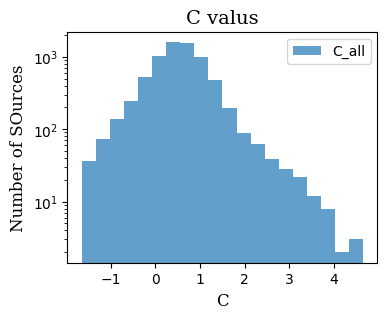

In [ ]:
# note, here we plot only dfz3['Z_Phot'] when dfz3['Z_Phot'] >= 0.0. keep this kind python sintax in mind
# and you can control the size of the figure, and font size
plt.figure(figsize=(4,3))

plt.hist( np.log10( df['C'][df['C']>0]), bins= 20, label="C_all", alpha=0.7 )
#plt.hist( df['C'], bins= 20, label="C_all", alpha=0.7 )


plt.legend(loc="upper right")
# Add title and axis names
plt.title('C valus', font='serif', size=14)
plt.xlabel('C', font='serif', size=12)
plt.ylabel('Number of SOurces', font='serif', size=12)

# set loglog scale
#plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:

# note, here we plot only dfz3['Z_Phot'] when dfz3['Z_Phot'] >= 0.0. keep this kind python sintax in mind
# and you can control the size of the figure, and font size
plt.figure(figsize=(9,7))

# define x and y values
xvalue =  df['S_PEAK']/df['VLA_rms']
yvalue =  df['S_INT']/df['S_PEAK']

# define C_lim
#C_lim = 5.6

plt.scatter( x = xvalue, y = yvalue, label="all", alpha=0.7 )

plt.scatter( x = xvalue[ df['C'] <= C_lim ], y = yvalue[ df['C']<=C_lim ], label=f"C<{C_lim}", alpha=0.5 )

plt.legend(loc="upper right")

# Add title and axis names
plt.title('Point Source Criteria', font='serif', size=14)
plt.xlabel('S_peak/rms_VLA'  , font='serif', size=12)
plt.ylabel('S_int/S_peak', font='serif', size=12)

# set log scale
plt.xscale('log')
plt.yscale('log')

# set plot limits
plt.ylim(0.6,7)

plt.show()

In [ ]:
######################
# Save the output df #
######################

# PSC: Point Source Criteria
df.to_csv(f"{path_z}/autodf/dfmig_PSC.csv")

## crossmatch: Notes 1

In [ ]:
# Find indices of objects in c2 that are closest to objects in c1
# So, in our case, c1 has the objects from df-big-area (dfmigh), and c2 has the ones from df-small-area (dfimo)
# the index of df-small-area (dfimo) that match objects in df-big-area (dfmig) will be kept and associated to each of the df-big-area (dfmig) objects 

idx, d2d, d3d = c1.match_to_catalog_sky(c2)

In [ ]:
#######################
# Internal crossmatch #
#######################

# To use internal cross match, set nthneighbor=2
# So, with nthneighbor=1, each object will be associated to itself 
# [confirm] with nthneighbor=2, we get the closest neighbor 
# [confirm] with nthneighbor=3, we get the second closest neighbor 
import astropy.coordinates as coord
idxint, d2dint, d3dint = coord.match_coordinates_sky(c1, c1, nthneighbor=2)

print(f"size of the array: {len(idxint)}")
idxint

size of the array: 9896


array([   3,    7,    4, ..., 9873, 9895, 9894])

This method is described here (with examples):

``` c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree, distance=distance1*u.kpc)```  

``` catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, distance=distance2*u.kpc)``` 

```idx, d2d, d3d = c.match_to_catalog_3d(catalog)```

" Now idx are indices into catalog that are the closest objects to each of the coordinates in c, d2d are the on-sky distances between them, and d3d are the 3-dimensional distances. Because coordinate objects support indexing, idx enables easy access to the matched set of coordinates in the catalog: " 

``` matches = catalog[idx] ``` 

https://docs.astropy.org/en/stable/coordinates/matchsep.html

https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html

In [ ]:
idx

array([2282, 2808, 2808, ..., 4667, 4369, 4369])

In [ ]:
#idx has the same number of entries as the number of objects in c1 (dfmig)
#tho check the size of 'idx', use len() ; because 'idx' is an array (not a dataframe)
print(f"The size of dfmig: {dfmig.shape[0]}, is the same as c1: {len(c1)}, because c1 stores the coordinates of all objects in dfmig")

print(f"and 'idx' has size: {len(idx)}. The very same size as dfmig.")
#idx stores the following info: 
#"For each dfmig object, who is the closest counterpart from the dfimo catalog?"
#For doing that, it uses the dfimo indexs 

The size of dfmig: 9896, is the same as c1: 9896, because c1 stores the coordinates of all objects in dfmig
and 'idx' has size: 9896. The very same size as dfmig.


In [ ]:
#if you check the minimum and maximum values stored in 'idx'
#you will see that it corresponds to the size of dfimo
print(f"The smalest index stored in idx: {idx.min()}")
print(f"The largest index stored in idx: {idx.max()}")
print(f"The size of dfimo: {dfimo.shape[0]}.")

#!!the diference between 'idx.max() and dfimo.shape[0]' is becuase indexs in Python always starts counting from 0 .

The smalest index stored in idx: 0
The largest index stored in idx: 5222
The size of dfimo: 5223.


In [ ]:
idx

array([2282, 2808, 2808, ..., 4667, 4369, 4369])

In [ ]:
#'d2d' stores info about the distance (in arcsec) between each dfmig source and its closest counterpart from dfimo
d2d

<Angle [0.20204642, 0.19843366, 0.19656825, ..., 0.2014559 , 0.20073291,
        0.20353275] deg>

In [ ]:
#to convert to deg or arcmin use
d2d_deg = d2d.deg
d2d_arcmin =d2d.arcmin

d2d_arcmin

array([12.12278513, 11.90601943, 11.79409488, ..., 12.08735392,
       12.04397434, 12.21196509])

In [ ]:
#Define the crossmatch radius
max_distance = 2 * u.arcsec # select the max_distance value in arcsec

max_distance = max_distance / u.arcsec # divide by u.arcsecd , to remove the units from max_distance

#matchs:   Keep objects from dfmig that are closer       than 'max_distance' from any object in dfimo 
#nomatchs: Keep objects from dfmig that are further away than 'max_distance' from any object in dfimo 
#In our case, dfmig is the lager area df, and dfimo is the smaller area df. 

#np.where 
#np.where is used to keep the index associated to a row where there is a match / or a no match
matchs = np.where(d2d.arcsec <= max_distance)   # keep the index from d2d for rows where there is a match between catalogs
nomatchs = np.where(d2d.arcsec > max_distance)  # keep the index from d2d for rows where there is no match between catalogs


In [ ]:
#'matchs' and 'nomatchs' are arrays that store the index of the objects that 'have' or 'do not have' a match
print(f"matchs: {matchs}")
print(f"nomatchs: {nomatchs}")
#nomatchs)

matchs: (array([ 507,  508,  513, ..., 9331, 9332, 9335]),)
nomatchs: (array([   0,    1,    2, ..., 9893, 9894, 9895]),)


In [ ]:
#Now, we know every object from dfmig that 'have' or 'do not have' a match with dfimo object
#The total size of (matchs + nomatchs), is the size of dfmig
total = len(nomatchs[0]) + len(matchs[0])
total

9896

In [ ]:
# The element 507 from mig is associated to element 2808 from imo. check idx[507]
idx[507]

2808

In [ ]:
# listrade_mig will keep the ra,dec from sources from dfmig that have no match with dfimo 
# listrade_imo will keep the ra,dec from sources from dfimo that have a match with dfmig 
listradec_mig = c1[nomatchs]
listradec_imo = c2[idx[matchs]]


In [ ]:
total = listradec_mig.shape[0] + listradec_imo.shape[0] # total number of sources in the final sample 

print(f'With match radius of {max_distance} arcsec, we will keep {listradec_mig.shape[0]} objects from df-large-area (df-mig), \nand will keep {listradec_imo.shape[0]} objects from df-small-area (df-mig). Total: {total}')

With match radius of 2.0 arcsec, we will keep 4842 objects from df-large-area (df-mig), 
and will keep 5054 objects from df-small-area (df-mig). Total: 9896


In [ ]:
#check the lists
display(listradec_mig)
display(listradec_imo)

In [ ]:
#listradec_s has the objects from the small sample that has a counterpart in the big sample.
#we need to check if those matches are the same if we run the cross-match in TopCat

### Implemented loop to build the subsamples 

Here we build the subsamples from dfs and dfb that will be kept. 
Those will be concatenated later. 

In [ ]:
#build final df - concatenate 

#ADVANCED
def selected(df, listradec):
    
  df_aux = pd.DataFrame(columns = df.columns)
    
  for i in range(len(listradec)):
    #print(i)
    selected_row = df[ (df['RA'] == listradec[i].ra) & (df['DEC'] == listradec[i].dec) ]
    # In case the position matches, we select the row
    df_aux = pd.concat([df_aux, selected_row], axis=0, ignore_index=True)
    # the selected row is concatenated into df_aux

  return df_aux 

In [ ]:
df_partb = selected(dfmig, listradec_mig)
df_parts = selected(dfimo, listradec_imo)

display(df_partb.head(2))
display(df_parts.head(2))

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,S_INT14,E_S_INT14,S_PEAK14,E_S_PEAK14,IM_MAJ,E_IM_MAJ,IM_MIN,E_IM_MIN,IM_PA,E_IM_PA,THETA_MAJ,E_THETA_MAJ,THETA_MIN,E_THETA_MIN,RESOLVED,ISL_RMS,GAUS_ID,SRC_ID,ISL_ID,Fluxfinal,SNR,POINT,DB_NAME
0,b'J100320.73+020931.7',150.836411,0.00029,2.15882,0.00030,0.000104,0.000029,0.000056,0.000011,1.304066e+09,0.000099,0.000028,0.000053,0.00001,0.00397,0.00087,0.00269,0.00045,137.587402,25.103121,0.00317,0.00109,0.00124,0.00098,0,0.00001,0,0,0,0.000104,5.550000,1.508368,mightee
1,b'J100320.26+021312.7',150.834427,0.00003,2.22022,0.00008,0.000370,0.000024,0.000248,0.000010,1.304925e+09,0.000353,0.000022,0.000236,0.00001,0.00364,0.00018,0.00234,0.00008,179.642227,4.725640,0.00274,0.00023,0.00000,0.00000,1,0.00001,1,1,1,0.000370,25.567009,1.059901,mightee


,CATID,GAUS_ID_NEW,RADIORA,RADIODEC,TOTALFLUX,TOTALFLUXERR,PEAKFLUX,PEAKFLUXERR,MATCHID,NCOMP,OPTICALRA,OPTICALDEC,FLAG,ID,X_IMAGE,Y_IMAGE,RA,DEC,flux_CFHT-u,flux_CFHT-g,flux_CFHT-r,flux_CFHT-iy,flux_CFHT-z,flux_HSC-G,flux_HSC-R,flux_HSC-I,flux_HSC-NB0816,flux_HSC-Z,flux_SC-z,flux_HSC-NB0921,flux_HSC-Y,flux_Y,flux_J,flux_H,flux_Ks,flux_ch1,flux_ch2,err_CFHT-u,err_CFHT-g,err_CFHT-r,err_CFHT-iy,err_CFHT-z,err_HSC-G,err_HSC-R,err_HSC-I,err_HSC-NB0816,err_HSC-Z,err_SC-z,err_HSC-NB0921,err_HSC-Y,err_Y,err_J,err_H,err_Ks,err_ch1,err_ch2,Separation_1,help_id_1,RA_2,Dec_2,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,Separation_1a,HELP_ID_2,RA_1a,Dec_1a,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,Separation_1b,RA_2a,Dec_2a,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_350,n_eff_SPIRE_500,Pval_res_250,Pval_res_350,Pval_res_500,help_id,Separation_1c,ALPHA_J2000,DELTA_J2000,SPLASH_1_FLUX,SPLASH_1_FLUX_ERR,SPLASH_2_FLUX,SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX,SPLASH_4_FLUX_ERR,COS_best_z_v5,COS_best_z_uncertainty_v5,COS_best_z_note_v5,DB_NAME


In [ ]:
print(f'df_partb shape: {df_partb.shape} ; and df_parts shape: {df_parts.shape} .')

df_partb shape: (4972, 33) ; and df_parts shape: (4924, 131) .


In [ ]:
df_parts['log_flux'] = np.log10(df_parts['TOTALFLUX'])
df_partb['log_flux'] = np.log10(df_partb['S_INT'])

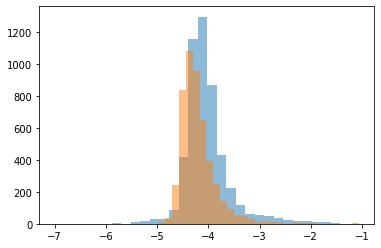

In [ ]:
plt.hist(df_partb['log_flux'], alpha=0.5, bins=30)
plt.hist(df_parts['log_flux'], alpha=0.5, bins=30)
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
#!!**TWO WAYS TO CONCATENATE**!!
# Create a new df, concatenating tables

df_new = pd.concat([df_partb[{'DB_NAME', 'RA', 'DEC', 'NAME', 'S_INT', 'E_S_INT'}], df_parts[{'DB_NAME', 'RA', 'DEC', 'CATID', 'TOTALFLUX', 'TOTALFLUXERR'}]], axis=0)
df_new.reset_index(drop=True, inplace=True)
df_new

,S_INT,DB_NAME,E_S_INT,DEC,NAME,RA,TOTALFLUXERR,CATID,TOTALFLUX
0,0.000104,mightee,0.000029,2.158820,b'J100320.73+020931.7',150.836411,NaN,NaN,NaN
1,0.000370,mightee,0.000024,2.220220,b'J100320.26+021312.7',150.834427,NaN,NaN,NaN
2,0.000075,mightee,0.000016,2.246450,b'J100319.37+021447.2',150.830734,NaN,NaN,NaN
3,0.000061,mightee,0.000018,2.166820,b'J100318.49+021000.5',150.827057,NaN,NaN,NaN
4,0.000164,mightee,0.000019,2.268550,b'J100317.73+021606.7',150.823883,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9891,NaN,imogen,NaN,2.164493,NaN,149.612387,0.000012,b'COSMOS02319',0.000035
9892,NaN,imogen,NaN,2.217085,NaN,149.607112,0.000012,b'COSMOS02658',0.000043
9893,NaN,imogen,NaN,2.190452,NaN,149.605852,0.000013,b'COSMOS02473',0.000048
9894,NaN,imogen,NaN,2.248969,NaN,149.604823,0.000013,b'COSMOS02914',0.000152


In [ ]:
#!!**TWO WAYS TO CONCATENATE**!!
# Or, if you want to keep the fluxes S_INT and TOTALFLUX in the same column, we need to rename them before concat(). 
# Concat will only add columns on top of the other, only if the columns have the same name
#'S_INT', 'E_S_INT'
df_partb['TOTALFLUX'] = df_partb['S_INT'] 
df_partb['TOTALFLUXERR'] = df_partb['E_S_INT']

df_parts['NAME'] = df_parts['CATID']

df_new2 = pd.concat([df_partb[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}], df_parts[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}]], axis=0)
df_new2.reset_index(drop=True, inplace=True)
df_new2

<ipython-input-62-1885a71e0304>:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_new2 = pd.concat([df_partb[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}], df_parts[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}]], axis=0)
<ipython-input-62-1885a71e0304>:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_new2 = pd.concat([df_partb[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}], df_parts[{'DB_NAME', 'RA', 'DEC', 'NAME', 'TOTALFLUX', 'TOTALFLUXERR'}]], axis=0)


,DEC,NAME,TOTALFLUXERR,RA,DB_NAME,TOTALFLUX
0,2.15882,b'J100320.73+020931.7',0.000029,150.836411,mightee,0.000104
1,2.22022,b'J100320.26+021312.7',0.000024,150.834427,mightee,0.000370
2,2.24645,b'J100319.37+021447.2',0.000016,150.830734,mightee,0.000075
3,2.16682,b'J100318.49+021000.5',0.000018,150.827057,mightee,0.000061
4,2.26855,b'J100317.73+021606.7',0.000019,150.823883,mightee,0.000164
...,...,...,...,...,...,...
4837,2.20009,b'J095738.17+021200.3',0.000017,149.409073,mightee,0.000052
4838,2.14895,b'J095738.01+020856.2',0.000015,149.408386,mightee,0.000064
4839,2.28432,b'J095737.51+021703.5',0.000019,149.406311,mightee,0.000127
4840,2.16462,b'J095736.94+020952.6',0.000014,149.403946,mightee,0.000076


In [ ]:
df_new2.to_csv('/content/drive/MyDrive/data/Module_DataWrang_2023_data/dfnew2.csv')

In [ ]:
df_new2 = pd.read_csv('/content/drive/MyDrive/data/Module_DataWrang_2023_data/dfnew2.csv')

In [ ]:
df_new2.head()

,Unnamed: 0,TOTALFLUXERR,DB_NAME,DEC,NAME,TOTALFLUX,RA
0,0,0.000029,mightee,2.15882,b'J100320.73+020931.7',0.000104,150.836411
1,1,0.000024,mightee,2.22022,b'J100320.26+021312.7',0.000370,150.834427
2,2,0.000016,mightee,2.24645,b'J100319.37+021447.2',0.000075,150.830734
3,3,0.000018,mightee,2.16682,b'J100318.49+021000.5',0.000061,150.827057
4,4,0.000019,mightee,2.26855,b'J100317.73+021606.7',0.000164,150.823883


In [ ]:
plt.hist(df_new2['RA'])
plt.show()

plt.hist(df_new2['DEC'])
plt.show()

plt.hist(df_new2['TOTALFLUX'], bins=20)
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.hist(df_new2['TOTALFLUXERR'], bins=20)
#plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
#Save the concatenated df in your folder
#compare to the same procedure done via TopCat

#df_new.to_csv('/content/drive/MyDrive/Colab Notebooks/SharedFolders/DaviBarbosa/concat_df.csv')
#This will save the file to your folder 'My Drive'
df_new.to_csv('/content/drive/MyDrive/concat_df.csv')
# save
df_new2.to_csv('/content/drive/MyDrive/concat_df2.csv')

## crossmatch: Notes 2

Xmatch [docs](http://cdsxmatch.u-strasbg.fr/xmatch/doc/API-calls.html)

Optional parameters (for Xmatch on CDS)

* 'selection' - match selection. Allowed values are best|all. Default selection mode is all. If the selection flag is not given, it will keep all matches within the search radius 

* if 'selection = all': all matches are kept. In this mode, the cross-match is symmetric.

* if 'selection = best': keep best match in cat2 for each row of cat1. In this mode, the cross-match is not symmetric.


* 'MAXREC' - the maximum number of rows to return. The server has a hard upper limit (currently set at $2\, 000\, 000$ records) which can not be overriden by the user.

In [ ]:
#Install Astroquery
!pip install astroquery

In [ ]:
#Install Astroquery
!pip install astroquery
import astroquery
from astroquery.vizier import Vizier


In [ ]:
#catalog_list = Vizier.find_catalogs('J/ApJS/249/17')
catalog_list = Vizier.find_catalogs('catwise')

#  print({k:v.description for k, v in catalog_list.items()})
print("A description for each table:")
for k, v in catalog_list.items():
  print({k:v.description})

In [ ]:
catTL = Vizier.get_catalogs(catalog='II/365')  #, return_type='votable')
catTL

#each Table inside a TableList is identified with a key
catTL.keys()

['II/365/catwise']

In [ ]:
df_new2.head()

,Unnamed: 0,TOTALFLUXERR,DB_NAME,DEC,NAME,TOTALFLUX,RA
0,0,0.000029,mightee,2.15882,b'J100320.73+020931.7',0.000104,150.836411
1,1,0.000024,mightee,2.22022,b'J100320.26+021312.7',0.000370,150.834427
2,2,0.000016,mightee,2.24645,b'J100319.37+021447.2',0.000075,150.830734
3,3,0.000018,mightee,2.16682,b'J100318.49+021000.5',0.000061,150.827057
4,4,0.000019,mightee,2.26855,b'J100317.73+021606.7',0.000164,150.823883


In [ ]:
#Install Astroquery
#!pip install astroquery
import astroquery
from astroquery.vizier import Vizier

from astroquery.xmatch import XMatch
from astropy.table import Table, join, vstack
from astropy import units as u 


# read the input (cat1) table
input_table = Table.read(f"/content/drive/MyDrive/data/Module_DataWrang_2023_data/dfnew2.csv")

XMatch.TIMEOUT = 150 

output_table = XMatch.query(cat1=input_table, cat2='vizier:II/365/catwise', max_distance=1.0 * u.arcsec,  
                     colRA1='RA', colDec1='DEC', 
                     all_columns=True, selection='best') # selection='best' 

# select only few columns
#columns = ['RA', 'DEC', 'other-columns-of-interest']
#output_table = Table(output_table[columns])

# Print table colums (use to select columns to keep)
print(f"The output_table has {len(output_table)} matches")
output_table.columns

The output_table has 5245 matches


<TableColumns names=('angDist','col0','TOTALFLUXERR','DB_NAME','DEC','NAME','TOTALFLUX','RA','objID','RAdeg','DEdeg','errHalfMaj','errHalfMin','errPosAng','Name','e_RAdeg','e_DEdeg','ePos','nW1','mW1','nW2','mW2','MJD','RAPMdeg','DEPMdeg','e_RAPMdeg','e_DEPMdeg','ePosPM','pmRA','pmDE','e_pmRA','e_pmDE','snrW1pm','snrW2pm','FW1pm','e_FW1pm','FW2pm','e_FW2pm','W1mproPM','e_W1mproPM','W2mproPM','e_W2mproPM','pmQual','Dist','chi2pmRA','chi2pmDE','ka','k1','k2','km','plx1','e_plx1','plx2','e_plx2','Sep','ccf','abfl')>

## add redshifts from z-lists: Notes 3

In [ ]:
# check on histogram of z values
plt.hist(dfz['lp_zBEST'], bins=15)

In [ ]:
# define object with coordinates from migh/imo cat
c1 = SkyCoord( ra = df['ra']*u.deg, dec=df['dec']*u.deg, frame='icrs')

# define object with coordinates associated to sources with measured redshift (z) 
c2 = SkyCoord(ra=dfz["ALPHA_J2000"]*u.deg, dec=dfz["DELTA_J2000"]*u.deg, frame='icrs')

In [ ]:
# define max_distance for the crossmatch
max_distance = 2  # arcsec

# for all objects in c1, get the closest sources (index) from c2. The distance is stored in d2d
idx, d2d, d3d = c1.match_to_catalog_sky(c2)

idx

array([324068, 173015, 396935, ..., 139549, 660692, 305078])

In [ ]:
# keep the index of the c1 objects where there is a match between catalogs
match = np.where(d2d.arcsec <= max_distance)   

match

(array([  60,   62,   63, ..., 9905, 9906, 9907]),)

In [ ]:
# the index of sources from c2 that have a match with c1
idxmatch = idx[match]
idxmatch

array([149122, 362700, 498991, ..., 139549, 660692, 305078])

In [ ]:
# If you df has no columns for z: create a column for redshift, fill it with np.nan values
df['z'] = np.nan
df.head(100)

In [ ]:
print(f"'match'is a tuple, that can carry many lists: {type(match)}")
match

(array([  60,   62,   63, ..., 9905, 9906, 9907]),)

In [ ]:
# this is the first list inside match
match[0]

array([  60,   62,   63, ..., 9905, 9906, 9907])

In [ ]:
# this is the first element of the first list inside match
match[0][0]

60

In [ ]:
# store the first list as 'matchlist' 
matchlist = match[0]
matchlist

array([  60,   62,   63, ..., 9905, 9906, 9907])

In [ ]:
# go through all elements from matchlist
# update redshift information in df['z']
for i in range(len(matchlist)): 
  #print(i)
  df['z'][matchlist[i]] = dfz['lp_zBEST'][idxmatch[i]]


df.head(100)

In [ ]:
# save. In case you have a new list with redshifts, repeat the process adding new redshifts
# the new redshift will be written over the previous redshifts 
# so, start from redshit table with lower priority
df.to_csv(f"{path_z}/auto_zlist_V1.csv")

## Extra notes

## comments on: read txt files

In [ ]:
#dfz1 = pd.read_csv(f'{path_z}/zcosmos.txt', delimiter='\s+', na_values=[""], header=0, names=["ALPHA_J2000", "DELTA_J2000", "lp_zBEST"], dtype={"ALPHA_J2000": float, "DELTA_J2000": float, "lp_zBEST": float})

## mask (selection)

In [ ]:
dfimo.head(10)

In [ ]:
c = SkyCoord(ra= dfimo['RADIORA']*u.deg , dec=dfimo['RADIODEC']*u.deg, frame='icrs' )

In [ ]:
cgal = c.galactic

In [ ]:
type(cgal)

astropy.coordinates.sky_coordinate.SkyCoord

In [ ]:
mask3 = ((dfimo['PEAKFLUX'] > 0.000017)  &  ( dfimo['TOTALFLUX'] > 0.000011	))

In [ ]:
dfsub = dfimo[ (dfimo['PEAKFLUX'] > 0.000017)  &  (dfimo['TOTALFLUX'] > 0.0000110000001) ]

In [ ]:
dfsub = dfimo[mask3]

In [ ]:
dfsub.head()

,CATID,GAUS_ID_NEW,RADIORA,RADIODEC,TOTALFLUX,TOTALFLUXERR,PEAKFLUX,PEAKFLUXERR,MATCHID,NCOMP,...,SPLASH_2_FLUX,SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX,SPLASH_4_FLUX_ERR,COS_best_z_v5,COS_best_z_uncertainty_v5,COS_best_z_note_v5,DB_NAME
3,b'COSMOS03590',b'4922 ',150.121689,2.341364,0.000011,0.000002,0.000039,0.000003,651541,1,...,6.724029,0.034050,5.565034,1.898968,4.089374,2.348022,2.28210,0.406829,b'photz ...,imogen
5,b'COSMOS01817',b'7346 ',149.888126,2.100928,0.000012,0.000006,0.000018,0.000004,429604,1,...,57.064743,0.228755,40.511284,6.091304,103.847076,6.464471,0.32260,0.029878,b'photz ...,imogen
7,b'COSMOS01073',b'6727 ',149.953102,1.977727,0.000012,0.000006,0.000017,0.000004,325459,1,...,12.484985,0.095901,9.556256,0.944491,5.095429,3.787379,1.44430,0.492298,b'photz ...,imogen
9,b'COSMOS03940',b'4273 ',150.190351,2.396921,0.000012,0.000005,0.000019,0.000004,695989,1,...,63.769943,0.141176,49.328861,5.544545,80.804260,6.529053,0.38472,-99.000000,"b'PRIMUS_93516,ZCOSMOS-DR3-831279 ...",imogen
11,b'COSMOS02574',b'2639 ',150.346875,2.213459,0.000013,0.000007,0.000017,0.000004,527119,1,...,46.550407,0.717059,34.382721,3.337761,21.056932,5.884245,0.49080,-99.000000,b'ZCOSMOS-DR3-823705 ...,imogen


In [ ]:
dfsub = dfimo[mask3]

In [ ]:
dfsub.head(10)

,CATID,GAUS_ID_NEW,RADIORA,RADIODEC,TOTALFLUX,TOTALFLUXERR,PEAKFLUX,PEAKFLUXERR,MATCHID,NCOMP,...,SPLASH_2_FLUX,SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX,SPLASH_4_FLUX_ERR,COS_best_z_v5,COS_best_z_uncertainty_v5,COS_best_z_note_v5,DB_NAME
3,b'COSMOS03590',b'4922 ',150.121689,2.341364,0.000011,0.000002,0.000039,0.000003,651541,1,...,6.724029,0.034050,5.565034,1.898968,4.089374,2.348022,2.28210,0.406829,b'photz ...,imogen
9,b'COSMOS03940',b'4273 ',150.190351,2.396921,0.000012,0.000005,0.000019,0.000004,695989,1,...,63.769943,0.141176,49.328861,5.544545,80.804260,6.529053,0.38472,-99.000000,"b'PRIMUS_93516,ZCOSMOS-DR3-831279 ...",imogen
12,b'COSMOS01455',b'4699 ',150.144463,2.046913,0.000013,0.000005,0.000023,0.000004,383022,1,...,44.971264,0.427106,31.879007,5.367891,73.430191,6.919528,0.36110,-99.000000,b'L492856 ...,imogen
13,b'COSMOS01556',b'7064 ',149.918617,2.059571,0.000014,0.000006,0.000018,0.000004,395942,1,...,46.095947,0.280605,30.905951,1.832845,28.753382,1.922794,1.07620,0.131847,b'photz ...,imogen
14,b'COSMOS02329',b'5499 ',150.074144,2.164162,0.000015,0.000007,0.000019,0.000004,492069,1,...,15.815037,0.119468,8.609430,3.219661,23.789949,4.915963,0.39930,0.051521,b'photz ...,imogen
15,b'COSMOS02797',b'8404 ',149.754111,2.246103,0.000015,0.000007,0.000022,0.000005,555638,1,...,34.761116,0.179678,29.575827,4.750748,15.958964,7.883203,0.72000,0.023420,b'photz ...,imogen
16,b'COSMOS02144',b'7696 ',149.842442,2.144625,0.000015,0.000007,0.000019,0.000005,469740,1,...,64.627083,0.310166,52.835251,6.809753,82.706375,7.716996,0.46583,-99.000000,b'PRIMUS_110966 ...,imogen
17,b'COSMOS03882',b'5652 ',150.060197,2.383121,0.000015,0.000006,0.000021,0.000004,688697,1,...,11.022186,0.066774,12.707266,3.213927,2.392025,3.866663,1.13750,0.379784,b'photz ...,imogen
19,b'COSMOS05208',b'3408 ',150.270491,2.637662,0.000015,0.000007,0.000023,0.000005,904171,1,...,19.466789,0.166684,12.590499,2.981349,12.183507,3.611462,0.92120,0.124446,b'photz ...,imogen
20,b'COSMOS03635',b'5957 ',150.029147,2.352001,0.000015,0.000006,0.000024,0.000004,658208,1,...,24.130096,0.092867,20.050030,3.384946,10.710385,5.435354,0.93000,-99.000000,b'L695185 ...,imogen


In [ ]:
mask2 = cgal.b.deg.between(237,237.1)

In [ ]:
dfisub2 = dfimo[]

In [ ]:
mask = c.b. > 2.1

In [ ]:
dfisub = dfimo[mask]

In [ ]:
dfisub.head()

,CATID,GAUS_ID_NEW,RADIORA,RADIODEC,TOTALFLUX,TOTALFLUXERR,PEAKFLUX,PEAKFLUXERR,MATCHID,NCOMP,...,SPLASH_2_FLUX,SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX,SPLASH_4_FLUX_ERR,COS_best_z_v5,COS_best_z_uncertainty_v5,COS_best_z_note_v5,DB_NAME
1,b'COSMOS03168',b'2177 ',150.399090,2.282900,0.000011,0.000006,0.000017,0.000004,599607,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.35370,0.820103,b'photz ...,imogen
2,b'COSMOS02147',b'1698 ',150.448082,2.140237,0.000011,0.000007,0.000017,0.000005,469924,1,...,23.210432,0.136891,17.975306,4.696359,10.507313,6.005375,1.20490,0.233585,b'photz ...,imogen
3,b'COSMOS03590',b'4922 ',150.121689,2.341364,0.000011,0.000002,0.000039,0.000003,651541,1,...,6.724029,0.034050,5.565034,1.898968,4.089374,2.348022,2.28210,0.406829,b'photz ...,imogen
4,b'COSMOS02963',b'4386 ',150.173247,2.260632,0.000011,0.000005,0.000017,0.000004,575173,1,...,17.199738,0.059445,15.211827,3.182418,3.783919,4.404816,0.93889,-99.000000,"b'PRIMUS_92812,ZCOSMOS-DR3-824507,3DHST_COSMOS...",imogen
5,b'COSMOS01817',b'7346 ',149.888126,2.100928,0.000012,0.000006,0.000018,0.000004,429604,1,...,57.064743,0.228755,40.511284,6.091304,103.847076,6.464471,0.32260,0.029878,b'photz ...,imogen


In [ ]:
c.dec.deg

array([2.08699974, 2.28290018, 2.14023706, ..., 2.67908734, 1.77026832,
       2.16604   ])